# *dandelion* Notebook-3
![dandelion_logo](img/dandelion_logo.png)

# BCR clustering and visualization

Now that we have both 1) a pre-processed BCR data and 2) matching `AnnData` object, we can start finding clones and *'integrate'* the results. All the BCR analyses files can be saved remain accessible externally in *.tsv* format so that it can be used in other tools like *immcantation*, *immunoarch*, *vdjtools*, *bcrep* etc., and only a few items will be added to the `AnnData` object, mainly for visualization purposes.

On the topic of finding clones, there are many ways used for identifying BCR clones, almost all involving some measure based on sequence similarity. There are also a lot of very well established guidelines and criterias maintained by the BCR community. For example, *immcantation* uses a number of model-based [methods](https://changeo.readthedocs.io/en/stable/methods/clustering.html) to group clones based on the distribution of length-normalised junctional hamming distance while [rbr1](https://www.well.ox.ac.uk/research/research-groups/bashford-rogers) developed a method to use the whole BCR VDJ sequence to define clones as shown in this recent [paper](https://www.nature.com/articles/s41586-019-1595-3.pdf). While these methods have mainly been applied to bulk BCR-seq protocols, they are biological grounded and should be applicable to single cells, as shown in immcantation's [method](https://changeo.readthedocs.io/en/stable/examples/10x.html).

# Finding clones

The following is *dandelion*'s implementation of a rather conventional method to define clones, `tl.find_clones`. 

Clone definition is based on the following criterias:

    (1) Identical IGH V-J gene usage.

    (2) Identical junctional sequence length.

    (3) Junctional sequences attains a minimum of % sequence similarity, based on hamming distance. The similarity cut-off is tunable (default is 85%).

    (4) Light chain usage. If cells within clones use different light chains, the clone will be splitted following the same conditions for heavy chains in (1-3) as above. 

The 'clone_id' name follows a `{A}_{B}_{C}_{D}` format and largely reflects the conditions above where:

    {A} indicates if the contigs use the same IGH V/J genes.
    
    {B} indicates if IGH junctional sequences are equal in length.
    
    {C} indicates if clones are splitted based on junctional hamming distance threshold
    
    {D} indicates light chain pairing. 

The last position will not be annotated if there's only one group of light chains usage detected in the clone.

So in essence, cloned flagged up in `{A}` through to `{D}` are evolutionary-related and those that actually encode productive chains in `{D}` (or `{C}`) would be functionally related.

#### Import modules

In [1]:
import os
import pandas as pd
os.chdir(os.path.expanduser('/Users/kt16/Documents/Github/dandelion'))
import dandelion as ddl
# change directory to somewhere more workable
os.chdir(os.path.expanduser('/Users/kt16/Documents/Clatworthy_scRNAseq/Ondrej/PIP/'))
# I'm importing scanpy here to make use of its logging module.
import scanpy as sc
sc.settings.verbosity = 3
import warnings
warnings.filterwarnings('ignore')

/Users/kt16/miniconda3/envs/dandelion/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


I will work with the same example from the previous notebook since I have the `AnnData` object saved and vdj table filtered.

#### Set up some variables

In [2]:
sample = 'Pan_T7918901'
bcr_folder = 'Pan_Immune_BCR/'
gex_folder = 'Pan_Immune_GEX/'
sampledict = ddl.utl.dict_from_table('/Users/kt16/Documents/Clatworthy_scRNAseq/Ondrej/dandelion_files/meta/PIP_sampleInfo_kt16.txt', columns = ('SANGER SAMPLE ID', 'GEX_SAMPLE_ID')) 
filtered_file = bcr_folder+sample+'/dandelion/data/all_contig_igblast_gap_genotyped_filtered.tsv'

## Running `tl.find_clones`
The function will take a file path, a pandas `DataFrame` (for example if you've used pandas to read in the filtered file already), or a `Dandelion` class object (described in next section). The default mode for calculation of junctional hamming distance is to use the junction amino acid sequences. If you want to do it via nucleotide, you can specify the option:
```python
clustering_by = 'nt'
```

If you want to use the alleles for defining V-J gene usuage, specify:
```python
by_alleles = True
```

In [3]:
results = ddl.tl.find_clones(filtered_file)

Finding clones


Finding clones based on heavy chains : 100%|██████████| 71/71 [00:00<00:00, 8721.24it/s]
Refining clone assignment based on light chain pairing : 100%|██████████| 92/92 [00:00<00:00, 1338.67it/s]


 finished: Updated Dandelion object: 
   'data', contig-indexed clone table
   'metadata', cell-indexed clone table
 (0:00:00)


In [4]:
results

Dandelion class object with n_obs = 246 and n_contigs = 474
    data: 'sequence_id', 'sequence_id.1', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'locus', 'stop_codon', 'vj_in_frame', 'sequence_alignment_aa', 'germline_alignment_aa', 'v_alignment_start', 'v_alignment_end', 'd_alignment_start', 'd_alignment_end', 'j_alignment_start', 'j_alignment_end', 'v_sequence_alignment', 'v_sequence_alignment_aa', 'v_germline_alignment', 'v_germline_alignment_aa', 'd_sequence_alignment', 'd_sequence_alignment_aa', 'd_germline_alignment', 'd_germline_alignment_aa', 'j_sequence_alignment', 'j_sequence_alignment_aa', 'j_germline_alignment', 'j_germline_alignment_aa', 'fwr1', 'fwr1_aa', 'cdr1', 'cdr1_aa', 'fwr2', 'fwr2_aa', 'cdr2', 'cdr2_aa', 'fwr3', 'fwr3_aa', 'fwr4', 'fwr4_aa', 'cdr3', 'cdr3_aa', 'junction_length', 'v_score', 'd_score', 'j_score', 'v_support', 'd_support', '

This will return a new column with the column name `'clone_id'` as per convention. If a filepath is provided as input, it will also save the file automatically into the base directory of the file name. Otherwise, if `Dandelion` object or pandas `DataFrame` is provided, the option `write_out` (default is `False`) will toggle whether to write the file and `outdir` and `outFilePrefix` will handle the out file directory and out file prefix respectively.

## Alternative : Running `tl.define_clones`

Alternatively, a wrapper to call *changeo's* `DefineClones.py` is also included. To run it, you need to choose the distance threshold for clonal assignment. To facilitate this, the function `pp.calculate_threshold` will run [shazam's distToNearest](https://shazam.readthedocs.io/en/stable/topics/distToNearest/) function and return a plot showing the length normalized hamming distance distribution and automated threshold value. Again, `pp.calculate_threshold` will take a file path, pandas `DataFrame` or `Dandelion` object as input. If a dandelion object is provided, the threshold value will be inserted into the `.threshold` slot. We will provide a copy of the object so that it doesn't overwrite the `clone_id` column from the step above.

### *pp.calculate_threshold*

Calculating threshold


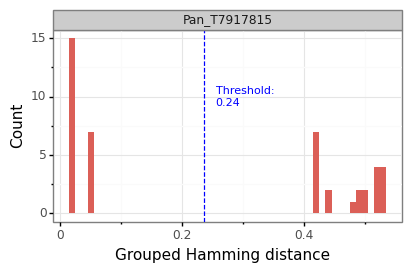

<ggplot: (322099417)>
 finished: Updated Dandelion object: 
   'threshold', threshold value for tuning clonal assignment
 (0:00:07)


In [5]:
ddl.pp.calculate_threshold(results)

In [6]:
# see the actual value in .threshold slot
results.threshold

0.2351300509492626

The results return says that the automated threshold is at the blue line but you can also use other values as long as you can justify it. You can use the same function to visualise a manual threshold value:

Calculating threshold


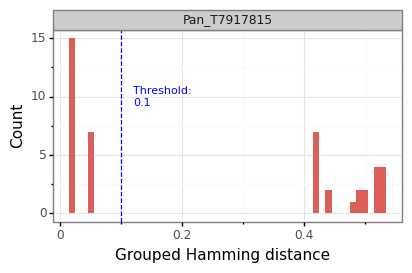

<ggplot: (348263181)>
 finished: Updated Dandelion object: 
   'threshold', threshold value for tuning clonal assignment
 (0:00:05)


In [7]:
ddl.pp.calculate_threshold(results, manual_threshold = 0.1)

In [8]:
# see the updated .threshold slot
results.threshold

0.1

### *tl.define_clones*

Now we can run `tl.define_clones` to call *changeo's* `DefineClones.py`; see [here](https://changeo.readthedocs.io/en/stable/methods/clustering.html) for more info. Note, if a pandas `DataFrame` or file path is provided as the input, the value in dist option (corresponds to threshold value) needs to be manually supplied. If a `Dandelion` object is provided, it will automatically retrieve it from the relevant slot. Note that this overwrites the `clone_id` column so stash that column or provide a copy of the object like what I did above.

In [9]:
ddl.tl.define_clones(results, key_added = 'changeo_clone_id')

Finding clones
 finished: Updated Dandelion object: 
   'data', contig-indexed clone table
   'metadata', cell-indexed clone table
 (0:00:04)


Note that I specified the option `key_added` and this adds the output from `tl.define_clones` into a separate column. If left as default (`None`), it will write into `clone_id` column. The same option can be specified in `tl.find_clones` earlier. If there is an existing column for `clone_id`, the group column for the new key would not be computed; If you want to extract the grouped column, simply run define clones without key_added to replace the existing `clone_id` and `clone_id_group` columns.

In [10]:
results.metadata

,sample_id,clone_id,clone_id_group,clone_id_by_size,isotype,lightchain,status,vdj_status,productive,umi_counts_heavy,umi_counts_light,v_call_heavy,v_call_light,j_call_heavy,j_call_light,c_call_heavy,c_call_light,changeo_clone_id
cell_id,,,,,,,,,,,,,,,,,,
Pan_T7917815_ACCTTTATCGCTTGTC,Pan_T7917815,20_1_1,20,98,IgG,IgK,IGH + IGK,Multi_heavy_v,T,2,42,"IGHV3-21,IGHV3-30",IGKV1D-12,IGHJ4,IGKJ5,IGHG2,IGKC,9_0
Pan_T7917815_ACTGCTCCAGGTCGTC,Pan_T7917815,56_2_1,56,76,IgM,IgK,IGH + IGK,Single,T,20,102,IGHV3-21,IGKV3-20,IGHJ4,IGKJ1,IGHM,IGKC,7_1
Pan_T7917815_CCTACCAGTGCCTTGG,Pan_T7917815,32_2_1,32,4,IgG,IgK,IGH + IGK,Single,T,143,422,IGHV4-34,IGKV3-11,IGHJ4,IGKJ4,IGHG3,IGKC,25_2
Pan_T7917815_CGATCGGAGGGCTCTC,Pan_T7917815,9_1_1,9,28,IgG,IgK,IGH + IGK,Multi_heavy_v,T,113,622,"IGHV1-69D,IGHV1-69",IGKV3-20,IGHJ4,IGKJ4,IGHG2,IGKC,28_3
Pan_T7917815_CGGACGTTCTTTAGGG,Pan_T7917815,51_2_1,51,91,IgG,IgK,IGH + IGK,"Multi_light_v,Multi_light_j",T,3,35,IGHV4-59,"IGKV1-39,IGKV1D-39",IGHJ5,IGKJ2,IGHG2,IGKC,30_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pan_T7917815_GCAGCCAAGTATTGGA,Pan_T7917815,50_1_1,50,54,IgG,IgK,IGH + IGK,Single,T,3,169,IGHV4-28,IGKV3-15,IGHJ4,IGKJ4,IGHG1,IGKC,74_89
Pan_T7917815_GTACTCCGTAGTAGTA,Pan_T7917815,29_1_1,29,49,NaN,IgL,IGH + IGL,Single,T,29,31,IGHV2-5,IGLV3-19,IGHJ4,IGLJ3,NaN,"IGLC,IGLC3",80_90
Pan_T7917815_TTGCCGTCAAGTCTGT,Pan_T7917815,31_2_1,31,3,IgA,IgK,IGH + IGK,Single,T,53,272,IGHV3-49,IGKV1-27,IGHJ4,IGKJ1,IGHA2,IGKC,76_22


Let's see what's the overall clone assign agreement.

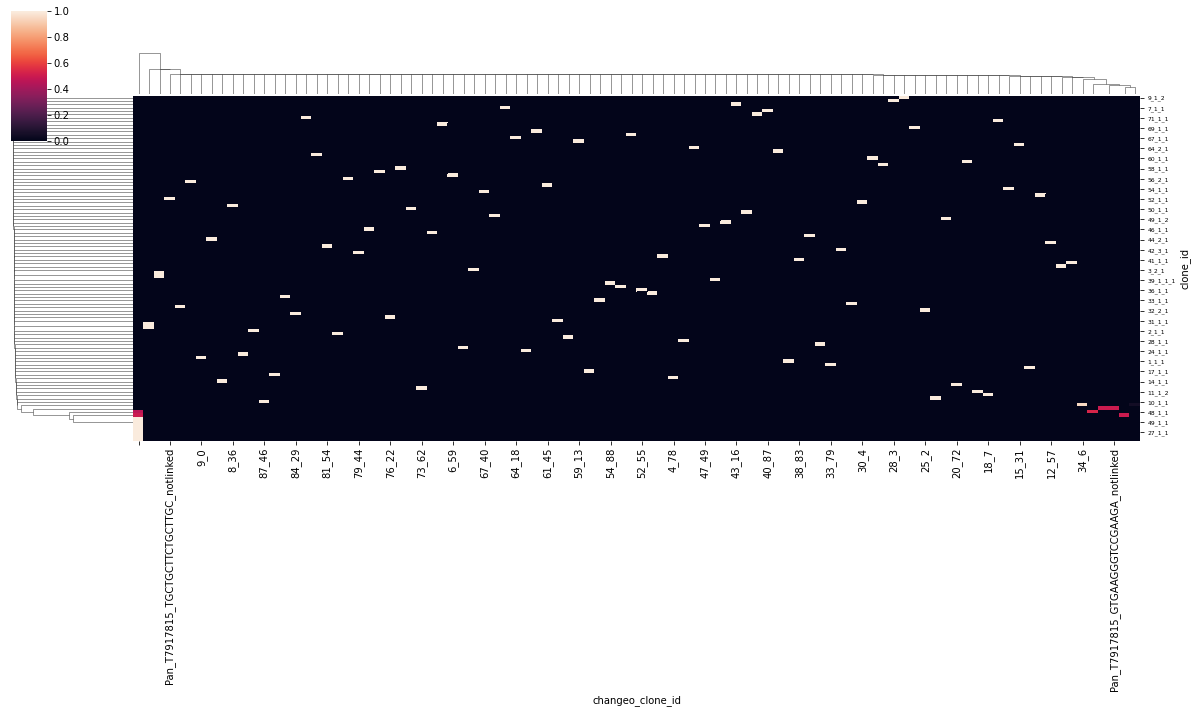

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = sns.clustermap(pd.crosstab(results.metadata["clone_id"], results.metadata["changeo_clone_id"], normalize="index"))
hm = cm.ax_heatmap.get_position()
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), fontsize=6)
cm.ax_heatmap.set_position([hm.x0, hm.y0, hm.width*2, hm.height])
col = cm.ax_col_dendrogram.get_position()
cm.ax_col_dendrogram.set_position([col.x0, col.y0, col.width*2, col.height*0.5])

### *Dandelion* class
You can see that the objects returned via the functions above are `Dandelion` objects, which is a python class holding the data:

In [12]:
results

Dandelion class object with n_obs = 246 and n_contigs = 474
    data: 'sequence_id', 'sequence_id.1', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'locus', 'stop_codon', 'vj_in_frame', 'sequence_alignment_aa', 'germline_alignment_aa', 'v_alignment_start', 'v_alignment_end', 'd_alignment_start', 'd_alignment_end', 'j_alignment_start', 'j_alignment_end', 'v_sequence_alignment', 'v_sequence_alignment_aa', 'v_germline_alignment', 'v_germline_alignment_aa', 'd_sequence_alignment', 'd_sequence_alignment_aa', 'd_germline_alignment', 'd_germline_alignment_aa', 'j_sequence_alignment', 'j_sequence_alignment_aa', 'j_germline_alignment', 'j_germline_alignment_aa', 'fwr1', 'fwr1_aa', 'cdr1', 'cdr1_aa', 'fwr2', 'fwr2_aa', 'cdr2', 'cdr2_aa', 'fwr3', 'fwr3_aa', 'fwr4', 'fwr4_aa', 'cdr3', 'cdr3_aa', 'junction_length', 'v_score', 'd_score', 'j_score', 'v_support', 'd_support', '

Essentially, the data slot holds the airr/changeo contig table while the metadata holds a collapsed version that is compatible with combining with `AnnData`'s `.obs` slot. The other slots will be gradually filled as we go through the notebook. You can retrieve these slots like a typical class object; for example, if I want the metadata:

In [13]:
results.metadata

,sample_id,clone_id,clone_id_group,clone_id_by_size,isotype,lightchain,status,vdj_status,productive,umi_counts_heavy,umi_counts_light,v_call_heavy,v_call_light,j_call_heavy,j_call_light,c_call_heavy,c_call_light,changeo_clone_id
cell_id,,,,,,,,,,,,,,,,,,
Pan_T7917815_ACCTTTATCGCTTGTC,Pan_T7917815,20_1_1,20,98,IgG,IgK,IGH + IGK,Multi_heavy_v,T,2,42,"IGHV3-21,IGHV3-30",IGKV1D-12,IGHJ4,IGKJ5,IGHG2,IGKC,9_0
Pan_T7917815_ACTGCTCCAGGTCGTC,Pan_T7917815,56_2_1,56,76,IgM,IgK,IGH + IGK,Single,T,20,102,IGHV3-21,IGKV3-20,IGHJ4,IGKJ1,IGHM,IGKC,7_1
Pan_T7917815_CCTACCAGTGCCTTGG,Pan_T7917815,32_2_1,32,4,IgG,IgK,IGH + IGK,Single,T,143,422,IGHV4-34,IGKV3-11,IGHJ4,IGKJ4,IGHG3,IGKC,25_2
Pan_T7917815_CGATCGGAGGGCTCTC,Pan_T7917815,9_1_1,9,28,IgG,IgK,IGH + IGK,Multi_heavy_v,T,113,622,"IGHV1-69D,IGHV1-69",IGKV3-20,IGHJ4,IGKJ4,IGHG2,IGKC,28_3
Pan_T7917815_CGGACGTTCTTTAGGG,Pan_T7917815,51_2_1,51,91,IgG,IgK,IGH + IGK,"Multi_light_v,Multi_light_j",T,3,35,IGHV4-59,"IGKV1-39,IGKV1D-39",IGHJ5,IGKJ2,IGHG2,IGKC,30_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pan_T7917815_GCAGCCAAGTATTGGA,Pan_T7917815,50_1_1,50,54,IgG,IgK,IGH + IGK,Single,T,3,169,IGHV4-28,IGKV3-15,IGHJ4,IGKJ4,IGHG1,IGKC,74_89
Pan_T7917815_GTACTCCGTAGTAGTA,Pan_T7917815,29_1_1,29,49,NaN,IgL,IGH + IGL,Single,T,29,31,IGHV2-5,IGLV3-19,IGHJ4,IGLJ3,NaN,"IGLC,IGLC3",80_90
Pan_T7917815_TTGCCGTCAAGTCTGT,Pan_T7917815,31_2_1,31,3,IgA,IgK,IGH + IGK,Single,T,53,272,IGHV3-49,IGKV1-27,IGHJ4,IGKJ1,IGHA2,IGKC,76_22


You can deep copy the `Dandelion` object to another variable which will inherit all slots:

In [14]:
results2 = results.copy()
results2.metadata

,sample_id,clone_id,clone_id_group,clone_id_by_size,isotype,lightchain,status,vdj_status,productive,umi_counts_heavy,umi_counts_light,v_call_heavy,v_call_light,j_call_heavy,j_call_light,c_call_heavy,c_call_light,changeo_clone_id
cell_id,,,,,,,,,,,,,,,,,,
Pan_T7917815_ACCTTTATCGCTTGTC,Pan_T7917815,20_1_1,20,98,IgG,IgK,IGH + IGK,Multi_heavy_v,T,2,42,"IGHV3-21,IGHV3-30",IGKV1D-12,IGHJ4,IGKJ5,IGHG2,IGKC,9_0
Pan_T7917815_ACTGCTCCAGGTCGTC,Pan_T7917815,56_2_1,56,76,IgM,IgK,IGH + IGK,Single,T,20,102,IGHV3-21,IGKV3-20,IGHJ4,IGKJ1,IGHM,IGKC,7_1
Pan_T7917815_CCTACCAGTGCCTTGG,Pan_T7917815,32_2_1,32,4,IgG,IgK,IGH + IGK,Single,T,143,422,IGHV4-34,IGKV3-11,IGHJ4,IGKJ4,IGHG3,IGKC,25_2
Pan_T7917815_CGATCGGAGGGCTCTC,Pan_T7917815,9_1_1,9,28,IgG,IgK,IGH + IGK,Multi_heavy_v,T,113,622,"IGHV1-69D,IGHV1-69",IGKV3-20,IGHJ4,IGKJ4,IGHG2,IGKC,28_3
Pan_T7917815_CGGACGTTCTTTAGGG,Pan_T7917815,51_2_1,51,91,IgG,IgK,IGH + IGK,"Multi_light_v,Multi_light_j",T,3,35,IGHV4-59,"IGKV1-39,IGKV1D-39",IGHJ5,IGKJ2,IGHG2,IGKC,30_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pan_T7917815_GCAGCCAAGTATTGGA,Pan_T7917815,50_1_1,50,54,IgG,IgK,IGH + IGK,Single,T,3,169,IGHV4-28,IGKV3-15,IGHJ4,IGKJ4,IGHG1,IGKC,74_89
Pan_T7917815_GTACTCCGTAGTAGTA,Pan_T7917815,29_1_1,29,49,NaN,IgL,IGH + IGL,Single,T,29,31,IGHV2-5,IGLV3-19,IGHJ4,IGLJ3,NaN,"IGLC,IGLC3",80_90
Pan_T7917815_TTGCCGTCAAGTCTGT,Pan_T7917815,31_2_1,31,3,IgA,IgK,IGH + IGK,Single,T,53,272,IGHV3-49,IGKV1-27,IGHJ4,IGKJ1,IGHA2,IGKC,76_22


The `Dandelion` class also contains read/write methods via `cPickle`, and `bzip2` for compression, to facilitate the storage of the data.

In [15]:
results.write('Pan_immune_BCR/Pan_T7918901/dandelion/data/dandelion_results.pkl.pbz2')

We use `ddl.read` to read in the object.

In [16]:
results3 = ddl.read('Pan_immune_BCR/Pan_T7918901/dandelion/data/dandelion_results.pkl.pbz2')
results3

Dandelion class object with n_obs = 246 and n_contigs = 474
    data: 'sequence_id', 'sequence_id.1', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'locus', 'stop_codon', 'vj_in_frame', 'sequence_alignment_aa', 'germline_alignment_aa', 'v_alignment_start', 'v_alignment_end', 'd_alignment_start', 'd_alignment_end', 'j_alignment_start', 'j_alignment_end', 'v_sequence_alignment', 'v_sequence_alignment_aa', 'v_germline_alignment', 'v_germline_alignment_aa', 'd_sequence_alignment', 'd_sequence_alignment_aa', 'd_germline_alignment', 'd_germline_alignment_aa', 'j_sequence_alignment', 'j_sequence_alignment_aa', 'j_germline_alignment', 'j_germline_alignment_aa', 'fwr1', 'fwr1_aa', 'cdr1', 'cdr1_aa', 'fwr2', 'fwr2_aa', 'cdr2', 'cdr2_aa', 'fwr3', 'fwr3_aa', 'fwr4', 'fwr4_aa', 'cdr3', 'cdr3_aa', 'junction_length', 'v_score', 'd_score', 'j_score', 'v_support', 'd_support', '

## Visualization of BCR network
*dandelion* generates a network to facilitate visualisation of results. This uses the full V(D)J contig sequences instead of just the junctional sequences to chart a tree-like network for each clone. The actual visualization will be achieved through `scanpy` later.

### Generate network
### *tl.generate_network*
First we need to generate the network. The tool function `tl.generate_network` will take a V(D)J table that has clones defined, specifically under the `'clone_id'` column. 

Again, the default mode is the use of amino acid sequences which can be toggled to using nucleotide sequences with:
```python
distance_mode = 'nt'
```

If you have a pre-processed table parsed from immcantation's [method](https://changeo.readthedocs.io/en/stable/examples/10x.html), or any other method as long as it's in a *changeo/airr tsv* format, the table can be used as well. The main option to consider adjusting here is the `clones_sep` option; this decides how the *'grouping'* of the clones would be performed during network construction. I'm expecting the clone to be annotated with some sort of separator, such as `_`, and the `clones_sep` option takes a tuple for the position (`int`) to return after split the clone name and the type of separator (`str`), in the following format:
```python
clones_sep = (int, str)
```

So for example, if my clone is called `21-A`, then the tuple to provide to `clones_sep` would be:
```python
clones_sep = (0, '-')
```

If no appropriate separators are found, it will not split the `clone_id` column and will just duplicate it in the new `clone_group` column in the metadata.

Below, I'm specifying `constructbygroup = True` as my dataset is quite sparse and I want to visualise clones shared by same V-J gene usage. The default is `False`.

In [17]:
ddl.tl.generate_network(results, constructbygroup = True)

Generating network


Linking edges : 100%|██████████| 102/102 [00:00<00:00, 686.91it/s]


generating network layout
 finished: Updated Dandelion object: 
   'data', contig-indexed clone table
   'metadata', cell-indexed clone table
   'distance', heavy and light chain distance matrices
   'edges', network edges
   'layout', network layout
   'graph', network (0:00:02)


##### check the newly re-initialized Dandelion object

In [18]:
results

Dandelion class object with n_obs = 246 and n_contigs = 474
    data: 'sequence_id', 'sequence_id.1', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'locus', 'stop_codon', 'vj_in_frame', 'sequence_alignment_aa', 'germline_alignment_aa', 'v_alignment_start', 'v_alignment_end', 'd_alignment_start', 'd_alignment_end', 'j_alignment_start', 'j_alignment_end', 'v_sequence_alignment', 'v_sequence_alignment_aa', 'v_germline_alignment', 'v_germline_alignment_aa', 'd_sequence_alignment', 'd_sequence_alignment_aa', 'd_germline_alignment', 'd_germline_alignment_aa', 'j_sequence_alignment', 'j_sequence_alignment_aa', 'j_germline_alignment', 'j_germline_alignment_aa', 'fwr1', 'fwr1_aa', 'cdr1', 'cdr1_aa', 'fwr2', 'fwr2_aa', 'cdr2', 'cdr2_aa', 'fwr3', 'fwr3_aa', 'fwr4', 'fwr4_aa', 'cdr3', 'cdr3_aa', 'junction_length', 'v_score', 'd_score', 'j_score', 'v_support', 'd_support', '

The graph/network can be accessed through the `.graph` slot as an `networkx` graph object if you want to extract the data for network statistics or make any changes to the network.

### *update_metadata*
Lastly, before continuing, the `.metadata` slot in Dandelion class automatically initializes whenever the `.data` slot is filled. However, it only returns a standard number of columns that are pre-specified. To retrieve other columns in the `.data` slot, we can update the metadata with `ddl.update_metadata` and specify the option `retrieve`. you can also pass `collapse = True` and `split_heavy_light = False` if the two columns can be reasonably combined for that cell/barcode.

In [19]:
# for example:
ddl.update_metadata(results) # only updates row entries if an existing .data and .metadata slot exists. Should retain existing columns
results

Dandelion class object with n_obs = 246 and n_contigs = 474
    data: 'sequence_id', 'sequence_id.1', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'locus', 'stop_codon', 'vj_in_frame', 'sequence_alignment_aa', 'germline_alignment_aa', 'v_alignment_start', 'v_alignment_end', 'd_alignment_start', 'd_alignment_end', 'j_alignment_start', 'j_alignment_end', 'v_sequence_alignment', 'v_sequence_alignment_aa', 'v_germline_alignment', 'v_germline_alignment_aa', 'd_sequence_alignment', 'd_sequence_alignment_aa', 'd_germline_alignment', 'd_germline_alignment_aa', 'j_sequence_alignment', 'j_sequence_alignment_aa', 'j_germline_alignment', 'j_germline_alignment_aa', 'fwr1', 'fwr1_aa', 'cdr1', 'cdr1_aa', 'fwr2', 'fwr2_aa', 'cdr2', 'cdr2_aa', 'fwr3', 'fwr3_aa', 'fwr4', 'fwr4_aa', 'cdr3', 'cdr3_aa', 'junction_length', 'v_score', 'd_score', 'j_score', 'v_support', 'd_support', '

In [20]:
ddl.update_metadata(results, retrieve = 'junction_aa')
results

Dandelion class object with n_obs = 246 and n_contigs = 474
    data: 'sequence_id', 'sequence_id.1', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'locus', 'stop_codon', 'vj_in_frame', 'sequence_alignment_aa', 'germline_alignment_aa', 'v_alignment_start', 'v_alignment_end', 'd_alignment_start', 'd_alignment_end', 'j_alignment_start', 'j_alignment_end', 'v_sequence_alignment', 'v_sequence_alignment_aa', 'v_germline_alignment', 'v_germline_alignment_aa', 'd_sequence_alignment', 'd_sequence_alignment_aa', 'd_germline_alignment', 'd_germline_alignment_aa', 'j_sequence_alignment', 'j_sequence_alignment_aa', 'j_germline_alignment', 'j_germline_alignment_aa', 'fwr1', 'fwr1_aa', 'cdr1', 'cdr1_aa', 'fwr2', 'fwr2_aa', 'cdr2', 'cdr2_aa', 'fwr3', 'fwr3_aa', 'fwr4', 'fwr4_aa', 'cdr3', 'cdr3_aa', 'junction_length', 'v_score', 'd_score', 'j_score', 'v_support', 'd_support', '

Note the additional columns in the metadata slot.

## Integration with scanpy
The results can also be ported into the `AnnData` object for access to more plotting functions provided through `scanpy`.

In [21]:
import warnings
warnings.filterwarnings('ignore')
sc.logging.print_versions()
adata = sc.read_h5ad(bcr_folder+sample+'/dandelion/data/adata.h5ad')
adata

scanpy==1.5.1 anndata==0.7.1 umap==0.4.3 numpy==1.17.5 scipy==1.5.2 pandas==1.1.0 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2 leidenalg==0.8.0


AnnData object with n_obs × n_vars = 834 × 3256 
    obs: 'sampleid', 'gender', 'donor', 'tissue', 'experiment', 'scrublet_score', 'n_genes', 'percent_mito', 'n_counts', 'bh_pval', 'is_doublet', 'filter_rna', 'filter_bcr_quality', 'filter_bcr_heavy', 'filter_bcr_light', 'filter_bcr', 'has_bcr', 'leiden'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'has_bcr_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

#### *tl.transfer*

To proceed, we first need to initialise the `AnnData` object with our network. This is done by using the tool function `tl.transfer`.

In [22]:
ddl.tl.transfer(adata, results)
adata

Transferring network
converting matrices
Updating anndata slots
 finished: updated `.obs` with `.metadata`
added to `.uns['neighbors']` and `.obsp`
   'distances', cluster-weighted adjacency matrix
   'connectivities', cluster-weighted adjacency matrix (0:00:00)


AnnData object with n_obs × n_vars = 834 × 3256 
    obs: 'sampleid', 'gender', 'donor', 'tissue', 'experiment', 'scrublet_score', 'n_genes', 'percent_mito', 'n_counts', 'bh_pval', 'is_doublet', 'filter_rna', 'filter_bcr_quality', 'filter_bcr_heavy', 'filter_bcr_light', 'filter_bcr', 'has_bcr', 'leiden', 'sample_id', 'clone_id', 'clone_id_group', 'clone_id_by_size', 'isotype', 'lightchain', 'status', 'vdj_status', 'productive', 'umi_counts_heavy', 'umi_counts_light', 'v_call_heavy', 'v_call_light', 'j_call_heavy', 'j_call_light', 'c_call_heavy', 'c_call_light', 'changeo_clone_id', 'junction_aa_heavy', 'junction_aa_light'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'has_bcr_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap', 'rna_neighbors'
    obsm: 'X_pca', 'X_umap', 'X_bcr'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'rna_connectivities', 'rna_distances', 'bcr_connectiv

You can see that `AnnData` object now contains a couple more columns in the `.obs` slot, corresponding to the metadata that is returned after `tl.generate_network`, and newly populated `.obsm` and `.obsp` slots. The original RNA connectivities and distances are now added into the `.obsp` slot as well.

## Plotting in scanpy

### *pl.clone_network*
So now, basically we can plot in `scanpy` with their plotting modules. I've included a plotting function in ***dandelion***, `pl.clone_network`, which is really just a wrapper of their `pl.embedding` module.

... storing 'sample_id' as categorical
... storing 'clone_id' as categorical
... storing 'clone_id_group' as categorical
... storing 'isotype' as categorical
... storing 'lightchain' as categorical
... storing 'status' as categorical
... storing 'vdj_status' as categorical
... storing 'productive' as categorical
... storing 'umi_counts_heavy' as categorical
... storing 'umi_counts_light' as categorical
... storing 'v_call_heavy' as categorical
... storing 'v_call_light' as categorical
... storing 'j_call_heavy' as categorical
... storing 'j_call_light' as categorical
... storing 'c_call_heavy' as categorical
... storing 'c_call_light' as categorical
... storing 'changeo_clone_id' as categorical
... storing 'junction_aa_heavy' as categorical
... storing 'junction_aa_light' as categorical
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

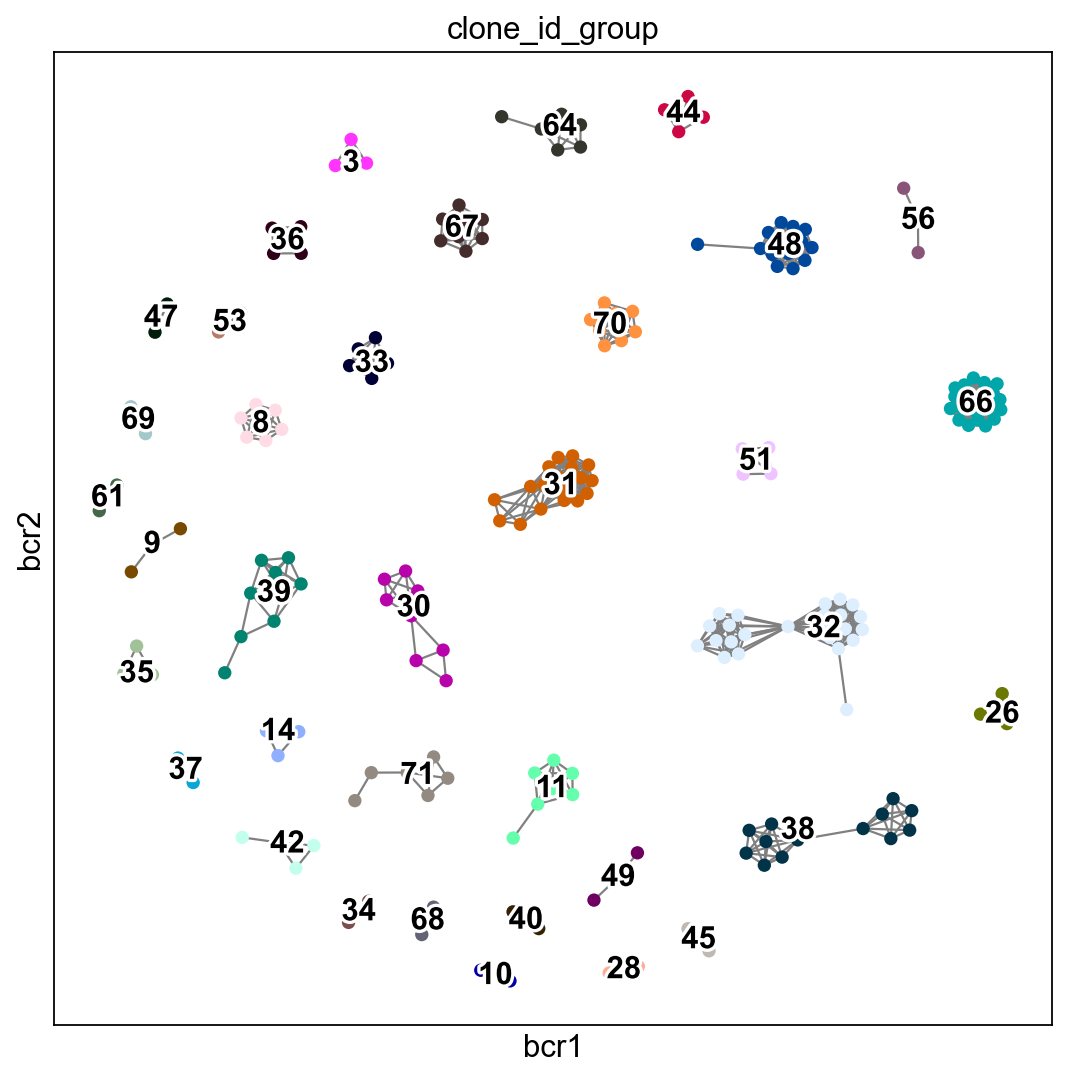

In [23]:
sc.set_figure_params(figsize = [8,8])
ddl.pl.clone_network(adata, 
                     color = ['clone_id_group'], 
                     legend_loc = 'on data',
                     legend_fontoutline=3,
                     edges_width = 1) 

***dandelion*** provides an edge weight extractor tool `tl.extract_edge_weights` to retrieve the edge weights that can be used to specify the widths according to weight/distance.

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

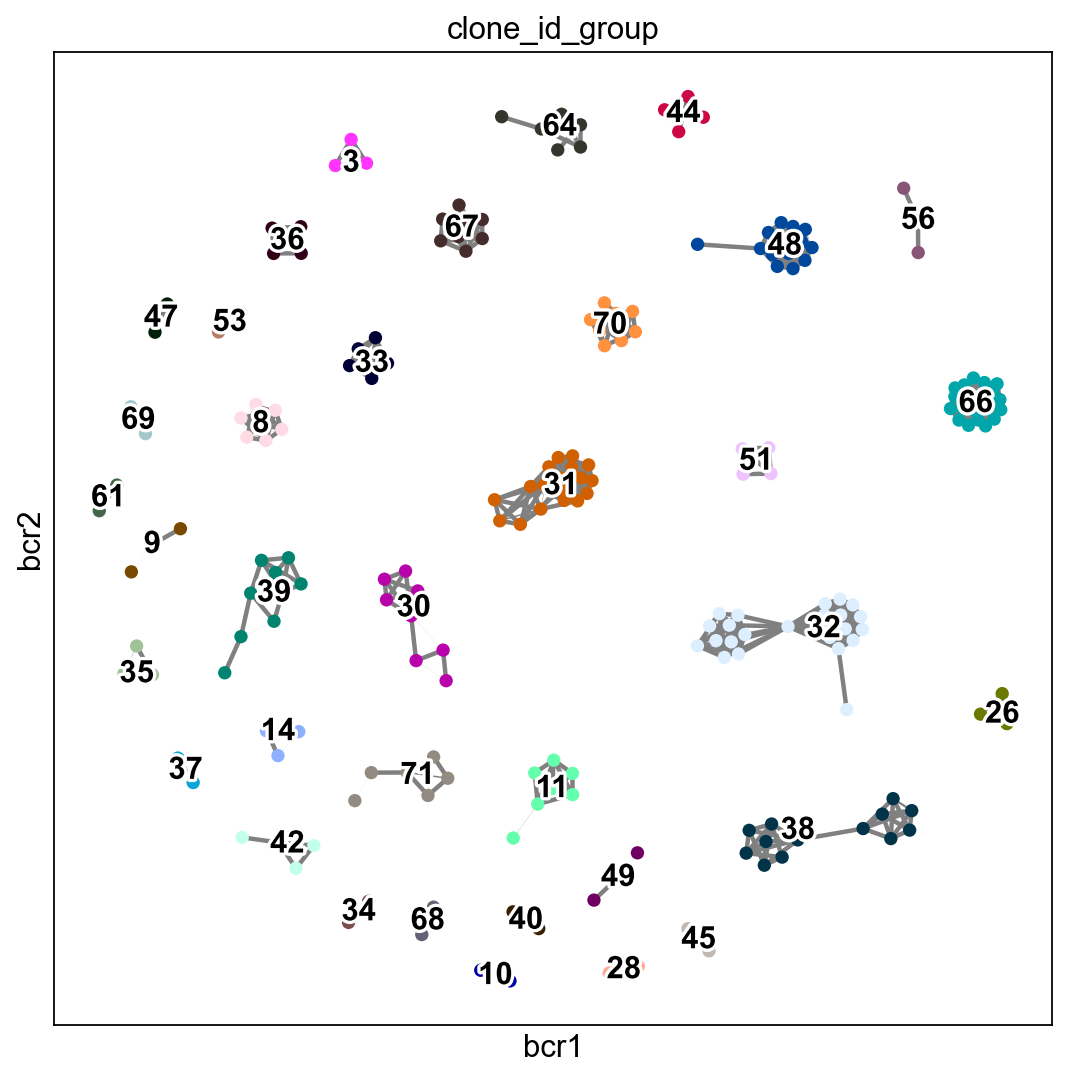

In [24]:
edgeweights = [2/(e+1) for e in ddl.tl.extract_edge_weights(results)] # add 1 to each edge weight (e) so that distance of 0 becomes the thickest edge
ddl.pl.clone_network(adata, 
                     color = ['clone_id_group'], 
                     legend_loc = 'on data', 
                     legend_fontoutline=3, 
                     edges_width = edgeweights) 

You can interact with `pl.clone_network` just as how you interact with the rest of the scatterplot modules in `scanpy`.

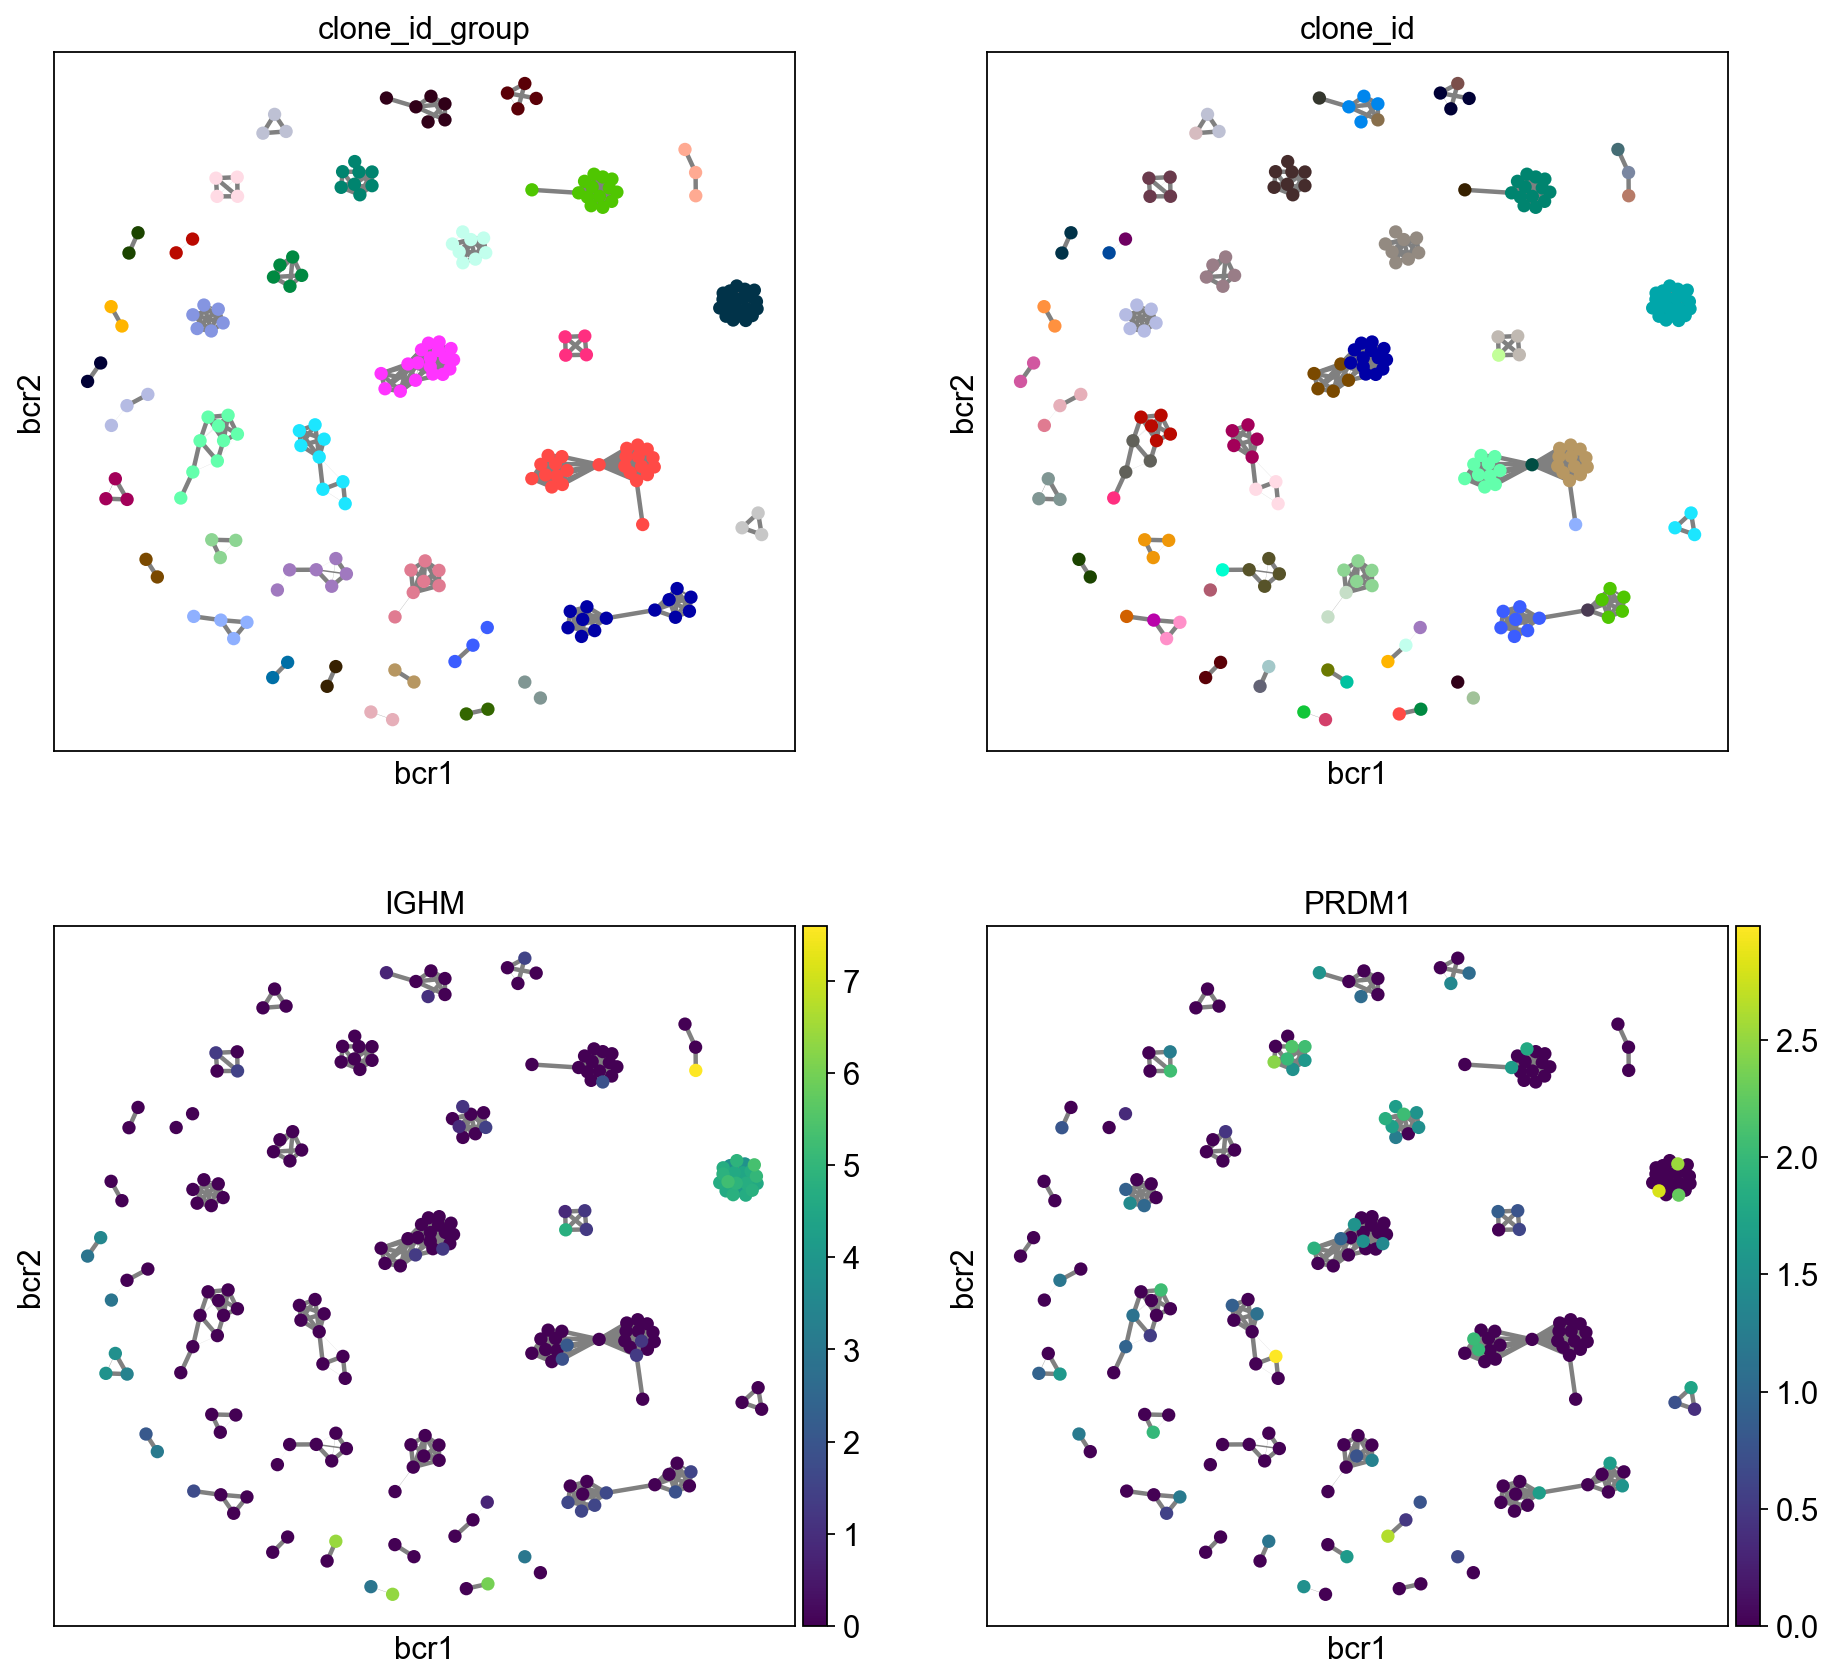

In [25]:
from scanpy.plotting.palettes import default_28, default_102
sc.set_figure_params(figsize = [6,6])
ddl.pl.clone_network(adata, color = ['clone_id_group', 'clone_id', 'IGHM', 'PRDM1'], ncols = 2, legend_loc = 'none', legend_fontoutline=3, edges_width = edgeweights, palette = default_28 + default_102, color_map = 'viridis')

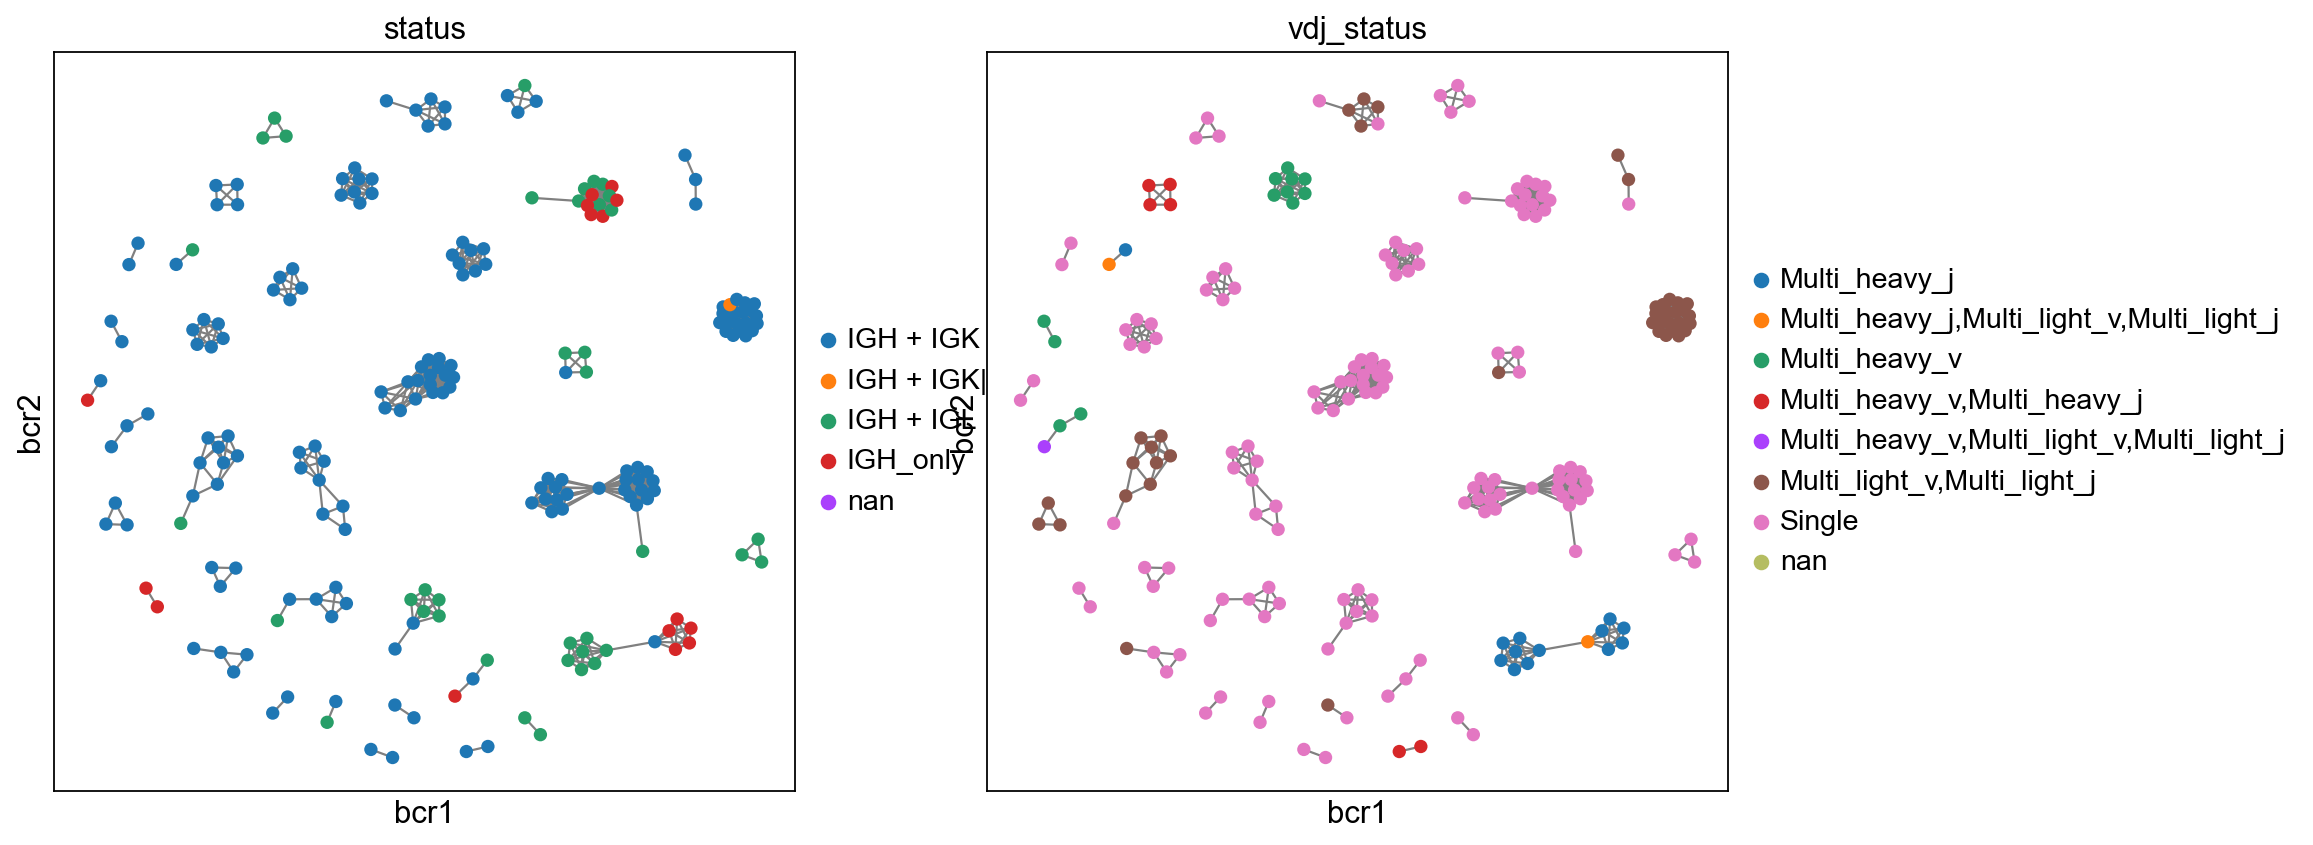

In [26]:
ddl.pl.clone_network(adata, color = ['status', 'vdj_status'], ncols = 2, legend_fontoutline=3, edges_width = 1)

### Calculating mutational load
To calculate mutational load, I've ported the functions from immcantation suite's changeo and shazam to work with the `dandelion` class object.

This can be run immediately after `pp.reassign_alleles` in notebook-1 because the required germline columns should be present in the genotyped `.tsv` file. The following example on `.update_germline` and `pp.create_germlines` is for if you are starting from a `Dandelion` object that contains the vdj data in the `.data` slot and want to redo the calculations, or adjust some things.

We first need to mask the D genes from the germline sequences with the tools function `pp.create_germlines`. **Note, this has been taken care of if you've already run `pp.reassign_alleles`.** You can store the germline reference updated with the personalized germline reference from `pp.reassign_alleles` within `Dandelion` object by running the following.

In [27]:
# if GERMLINE environmental variable is not set or swapping/using a different germline reference, please specify the `germline` option with the path to the database or the germline reference as a dictionary.
results.update_germline(corrected = bcr_folder+'A31/dandelion/data/all_contig_heavy_igblast_gap_genotype.fasta', germline = None, org = 'human')

Updating germline reference
 finished: Updated Dandelion object: 
   'germline', updated germline reference
 (0:00:00)


### *pp.create_germlines*

Then we run `pp.create_germline` to create the `germline_alignment_d_mask` column in the data. If `update_germline` was run like above, there's no need to specify the `germline` option as the function will simply retrieve it from the `Dandelion` object. As mentioned, **this has been taken care of if you've already run `pp.reassign_alleles`** and there's no need to run it.

*Note: the ability to run the original CreateGermlines.py with --cloned option is not currently possible through Dandelion and I would reccomend for you to run that separately if you intend to.*

In [28]:
ddl.pp.create_germlines(results)

Reconstructing germline sequences


   Building dmask germline sequences: 474it [00:00, 769.38it/s]


 finished: Updated Dandelion object: 
   'data', updated germline alignment in contig-indexed clone table
   'germline', updated germline reference
 (0:00:01)


The default behaviour is to mask the D with Ns `germ_types = 'dmask'`. See [here](https://changeo.readthedocs.io/en/stable/methods/germlines.html) for more info. Here, I'm updating the original germline_alignment column with the corrected alignment:

In [29]:
ddl.pp.create_germlines(results, germ_types = 'full')

Reconstructing germline sequences


   Building full germline sequences: 474it [00:00, 862.69it/s]


 finished: Updated Dandelion object: 
   'data', updated germline alignment in contig-indexed clone table
   'germline', updated germline reference
 (0:00:01)


### *pp.quantify_mutations*
The options for quantify_mutations are the same as the basic mutational load analysis [vignette](https://shazam.readthedocs.io/en/version-0.1.8---mutation-profiling-enhancements/vignettes/Mutation-Vignette/). The default behavior is to sum all mutations scores (heavy and light chains, silent and replacement mutations) for the same cell.

Again, this function can be run immediately after `pp.reassign_alleles` on the genotyped `.tsv` files (without loading into `pandas` or `Dandelion`). Here I'm illustrating a few other options that may be useful.

In [30]:
ddl.pp.quantify_mutations(results)

Quantifying mutations
 finished: Updated Dandelion object: 
   'data', contig-indexed clone table
   'metadata', cell-indexed clone table
 (0:00:02)


If you want to split the calculation up between replacement (R) and silent (S) mutations, specify `combine = False`.

In [31]:
ddl.pp.quantify_mutations(results, combine = False)

Quantifying mutations
 finished: Updated Dandelion object: 
   'data', contig-indexed clone table
   'metadata', cell-indexed clone table
 (0:00:02)


Specifying `split_locus = True` will split up the results for the different chains.

In [32]:
ddl.pp.quantify_mutations(results, split_locus = True)

Quantifying mutations
 finished: Updated Dandelion object: 
   'data', contig-indexed clone table
   'metadata', cell-indexed clone table
 (0:00:02)


To update the `AnnData` object, simply rerun `tl.transfer_network` with keep_raw option set to `False` to avoid overwriting the stashed neighborhood graph.

In [33]:
ddl.tl.transfer(adata, results)

Transferring network
converting matrices
Updating anndata slots
 finished: updated `.obs` with `.metadata`
added to `.uns['neighbors']` and `.obsp`
   'distances', cluster-weighted adjacency matrix
   'connectivities', cluster-weighted adjacency matrix (0:00:00)


... storing 'sample_id' as categorical
... storing 'clone_id' as categorical
... storing 'clone_id_group' as categorical
... storing 'isotype' as categorical
... storing 'lightchain' as categorical
... storing 'status' as categorical
... storing 'vdj_status' as categorical
... storing 'productive' as categorical
... storing 'umi_counts_heavy' as categorical
... storing 'umi_counts_light' as categorical
... storing 'v_call_heavy' as categorical
... storing 'v_call_light' as categorical
... storing 'j_call_heavy' as categorical
... storing 'j_call_light' as categorical
... storing 'c_call_heavy' as categorical
... storing 'c_call_light' as categorical
... storing 'changeo_clone_id' as categorical
... storing 'junction_aa_heavy' as categorical
... storing 'junction_aa_light' as categorical


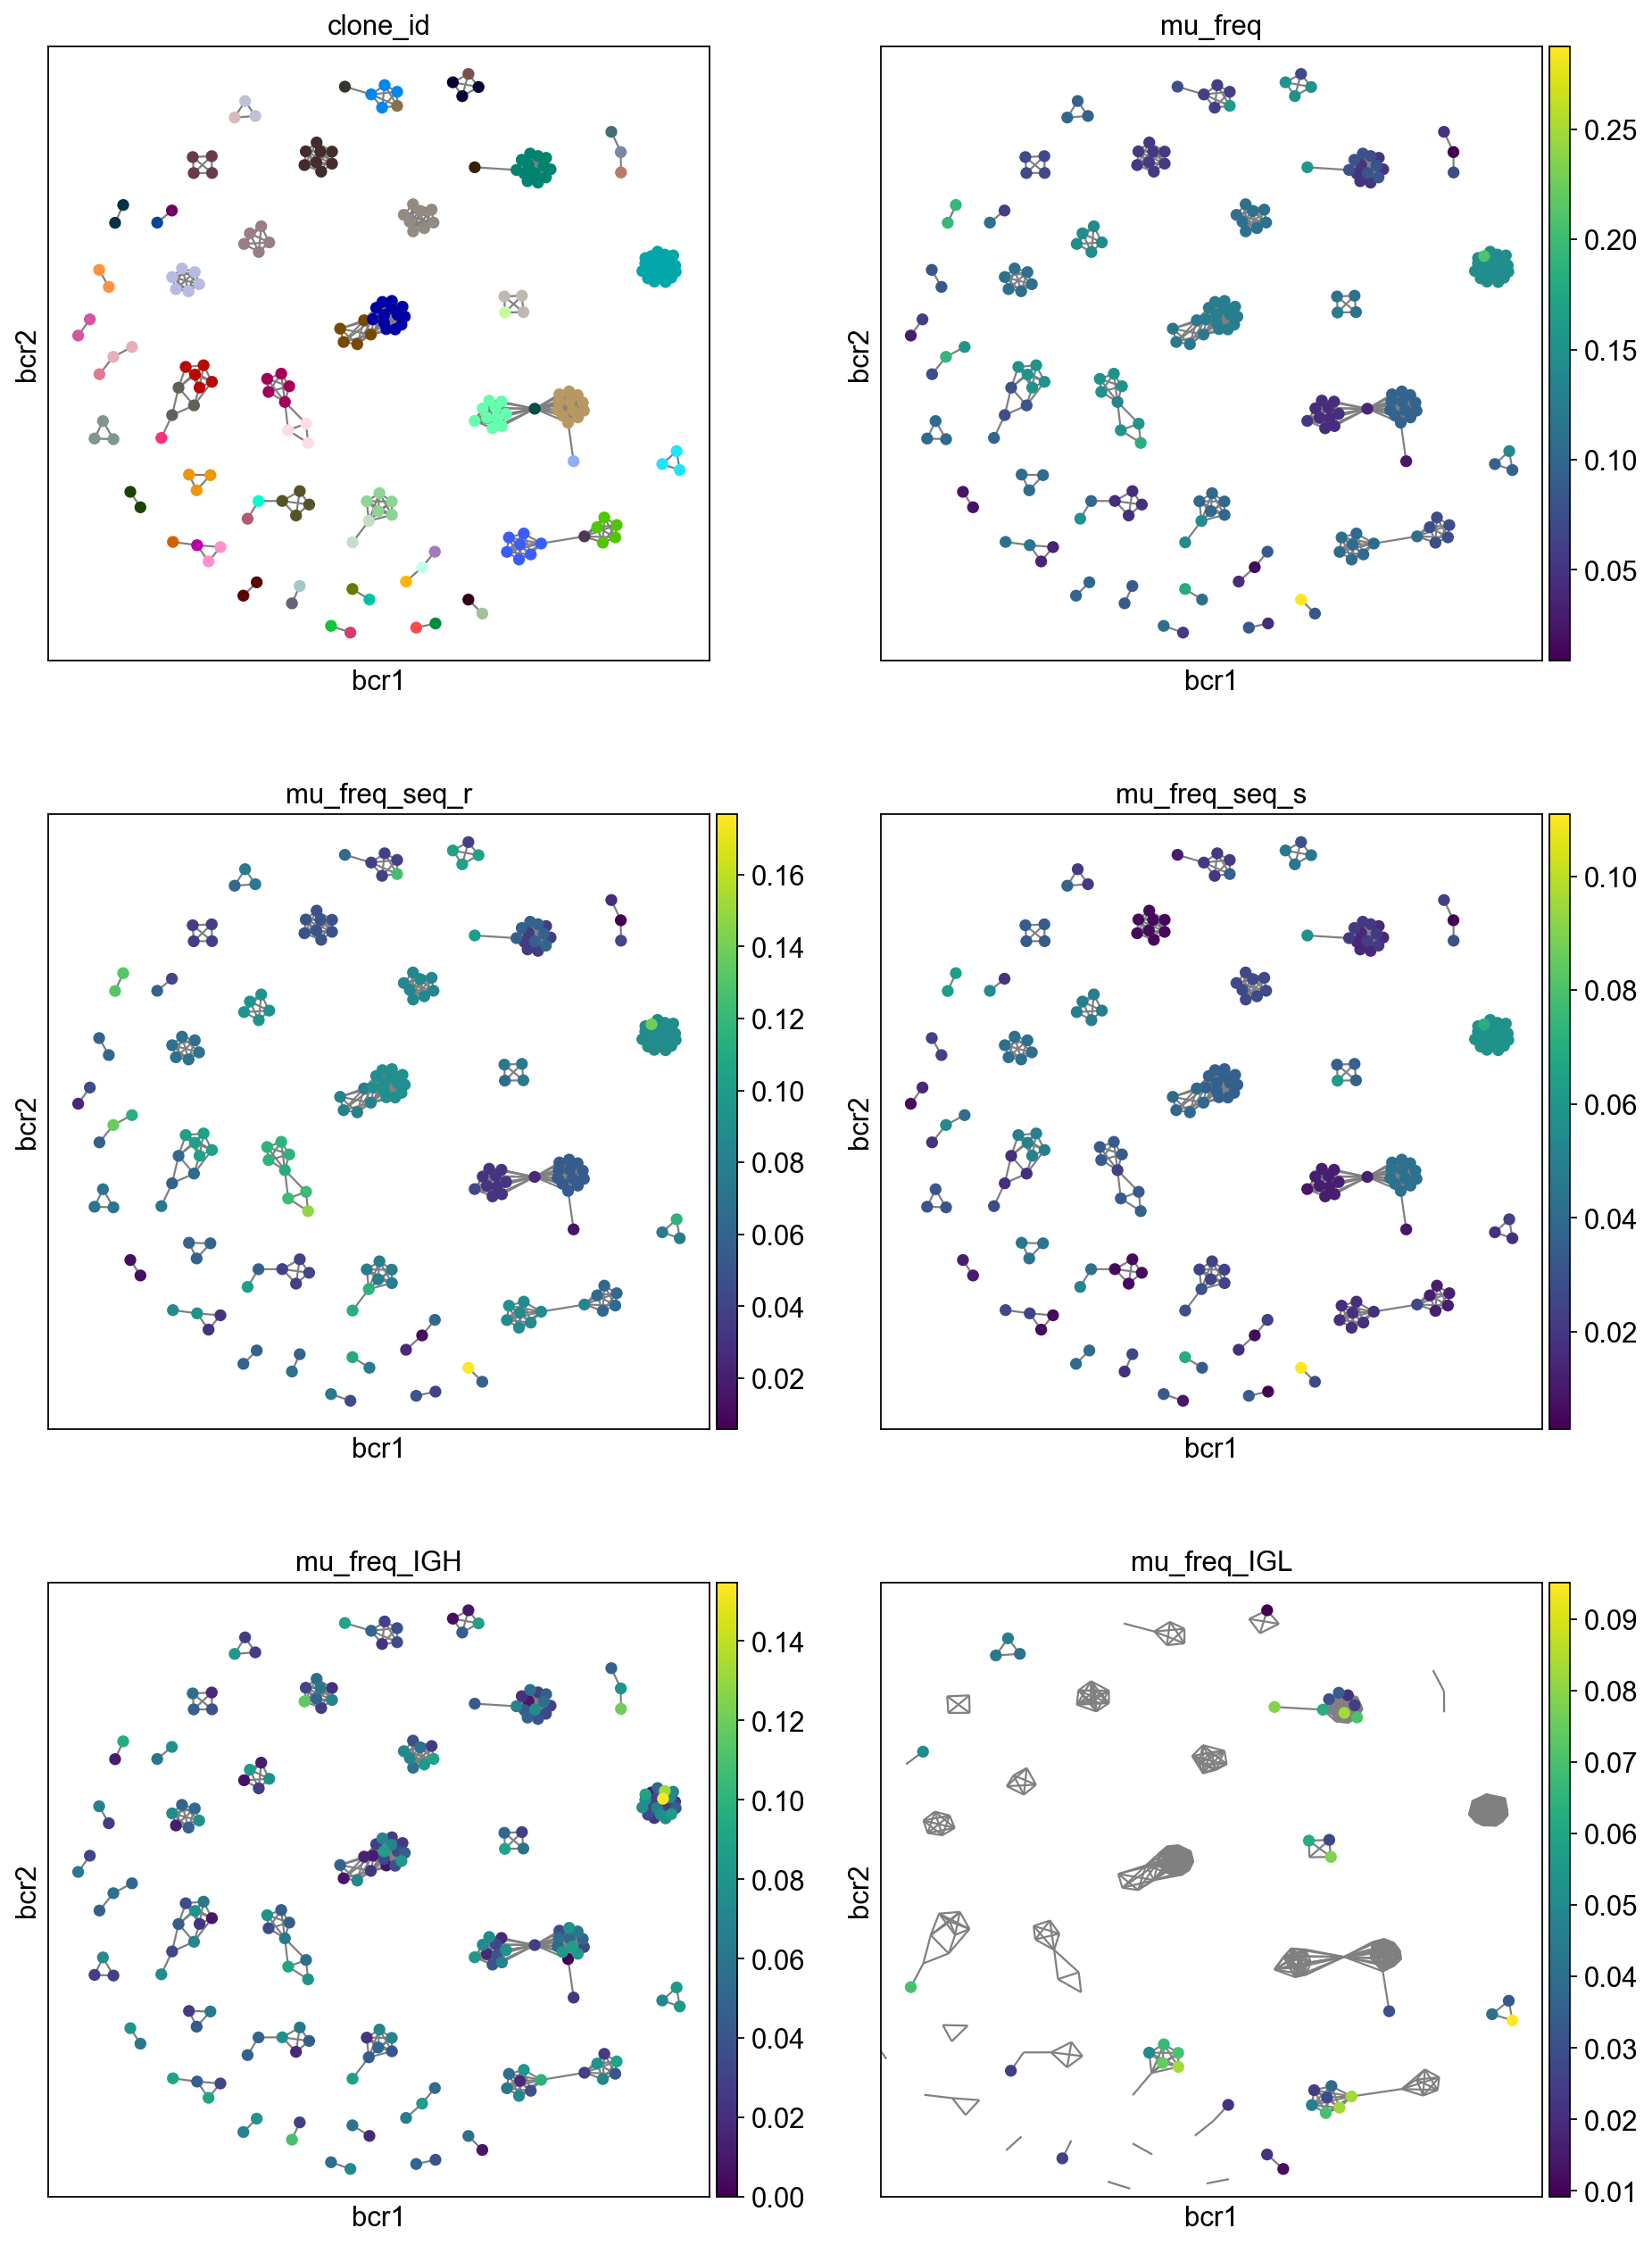

In [34]:
sc.set_figure_params(figsize = [6,6])
ddl.pl.clone_network(adata, color = ['clone_id', 'mu_freq', 'mu_freq_seq_r', 'mu_freq_seq_s', 'mu_freq_IGH', 'mu_freq_IGL'], ncols = 2, legend_loc = 'none', legend_fontoutline=3, edges_width = 1, palette = default_28 + default_102, color_map = 'viridis')

## Calculating size of clones

### *tl.clone_size*

Sometimes it's useful to evaluate the size of the clone. Here `tl.quantify_clone_size` does a simple calculation to enable that.

In [35]:
ddl.tl.clone_size(results)
ddl.tl.transfer(adata, results)

Quantifying clone sizes
 finished: Updated Dandelion object: 
   'metadata', cell-indexed clone table (0:00:00)
Transferring network
converting matrices
Updating anndata slots
 finished: updated `.obs` with `.metadata`
added to `.uns['neighbors']` and `.obsp`
   'distances', cluster-weighted adjacency matrix
   'connectivities', cluster-weighted adjacency matrix (0:00:00)


... storing 'sample_id' as categorical
... storing 'clone_id' as categorical
... storing 'clone_id_group' as categorical
... storing 'isotype' as categorical
... storing 'lightchain' as categorical
... storing 'status' as categorical
... storing 'vdj_status' as categorical
... storing 'productive' as categorical
... storing 'umi_counts_heavy' as categorical
... storing 'umi_counts_light' as categorical
... storing 'v_call_heavy' as categorical
... storing 'v_call_light' as categorical
... storing 'j_call_heavy' as categorical
... storing 'j_call_light' as categorical
... storing 'c_call_heavy' as categorical
... storing 'c_call_light' as categorical
... storing 'changeo_clone_id' as categorical
... storing 'junction_aa_heavy' as categorical
... storing 'junction_aa_light' as categorical


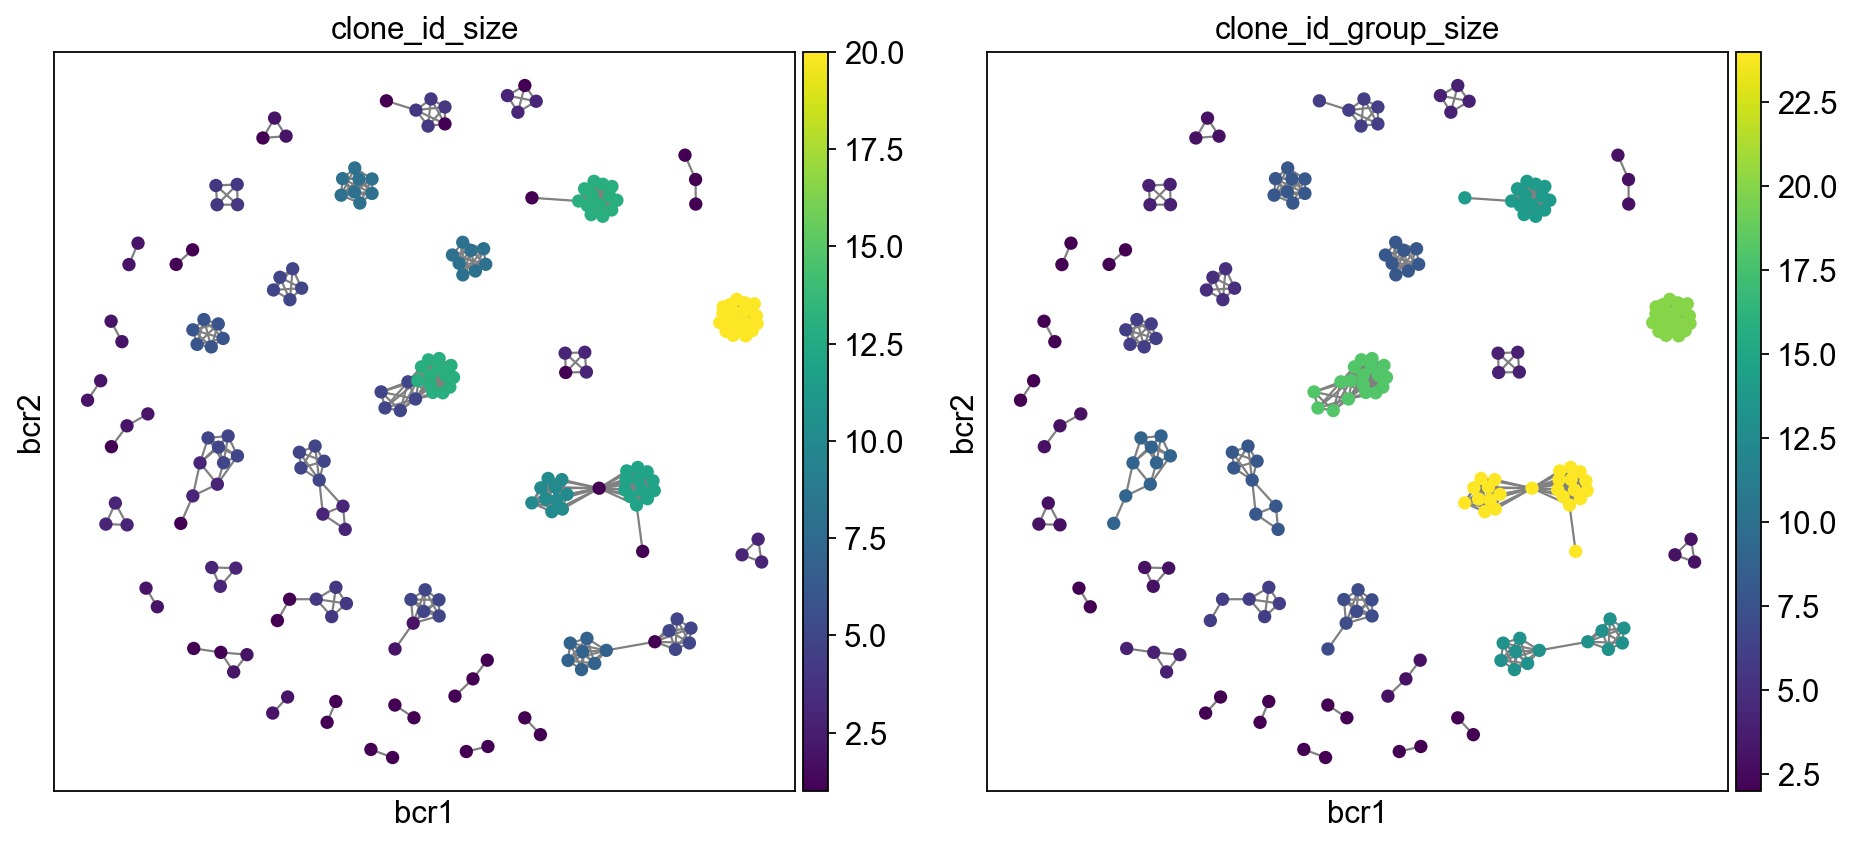

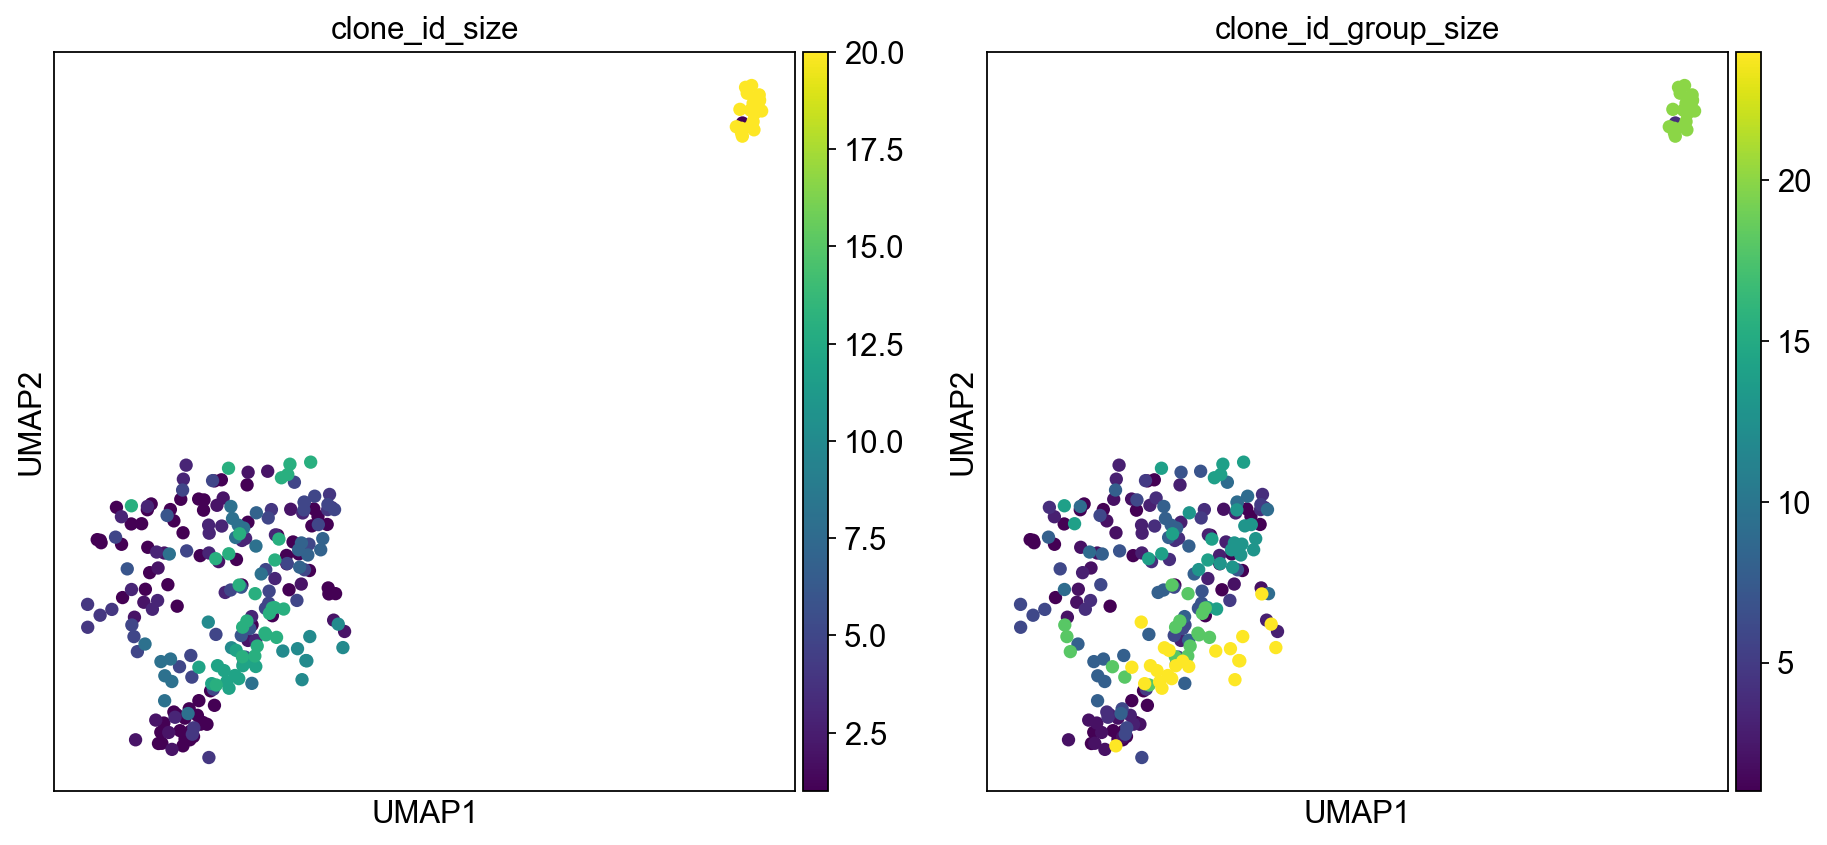

In [36]:
ddl.pl.clone_network(adata, color = ['clone_id_size', 'clone_id_group_size'], ncols = 2, legend_loc = 'none', legend_fontoutline=3, edges_width = 1)
sc.pl.umap(adata, color = ['clone_id_size', 'clone_id_group_size'])

You can also specify `max_size` to clip off the calculation at a fixed value.

In [37]:
ddl.tl.clone_size(results, max_size = 5)
ddl.tl.transfer(adata, results)

Quantifying clone sizes
 finished: Updated Dandelion object: 
   'metadata', cell-indexed clone table (0:00:00)
Transferring network
converting matrices
Updating anndata slots
 finished: updated `.obs` with `.metadata`
added to `.uns['neighbors']` and `.obsp`
   'distances', cluster-weighted adjacency matrix
   'connectivities', cluster-weighted adjacency matrix (0:00:00)


... storing 'sample_id' as categorical
... storing 'clone_id' as categorical
... storing 'clone_id_group' as categorical
... storing 'isotype' as categorical
... storing 'lightchain' as categorical
... storing 'status' as categorical
... storing 'vdj_status' as categorical
... storing 'productive' as categorical
... storing 'umi_counts_heavy' as categorical
... storing 'umi_counts_light' as categorical
... storing 'v_call_heavy' as categorical
... storing 'v_call_light' as categorical
... storing 'j_call_heavy' as categorical
... storing 'j_call_light' as categorical
... storing 'c_call_heavy' as categorical
... storing 'c_call_light' as categorical
... storing 'changeo_clone_id' as categorical
... storing 'junction_aa_heavy' as categorical
... storing 'junction_aa_light' as categorical
... storing 'clone_id_size' as categorical
... storing 'clone_id_group_size' as categorical


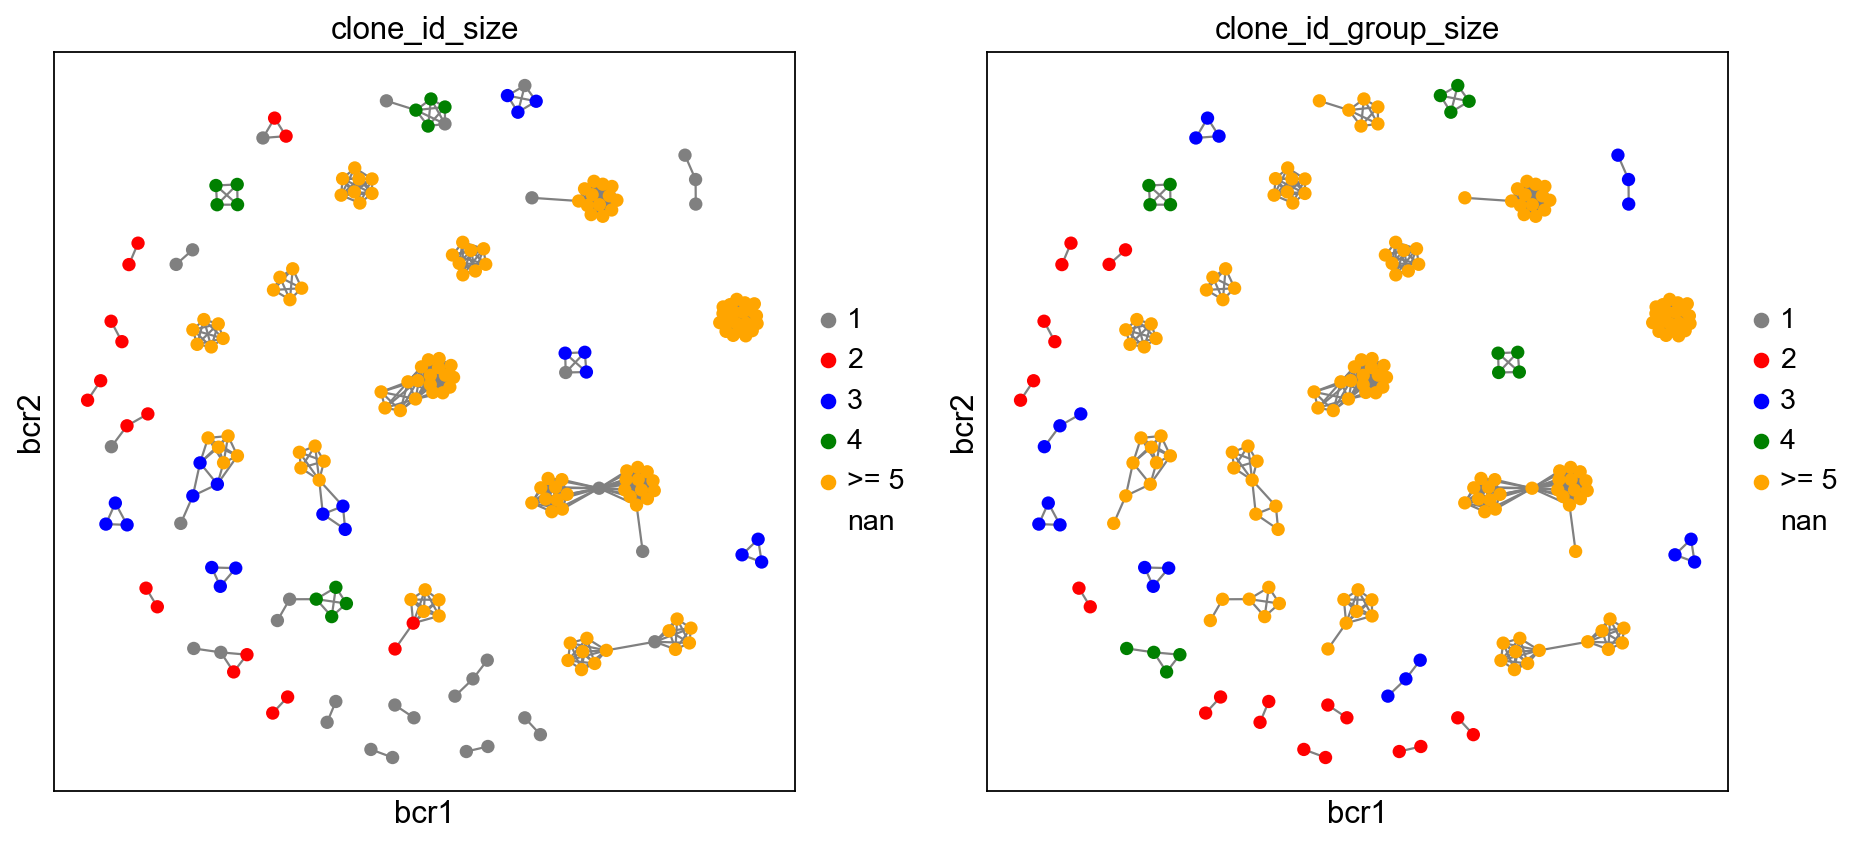

Trying to set attribute `.uns` of view, copying.


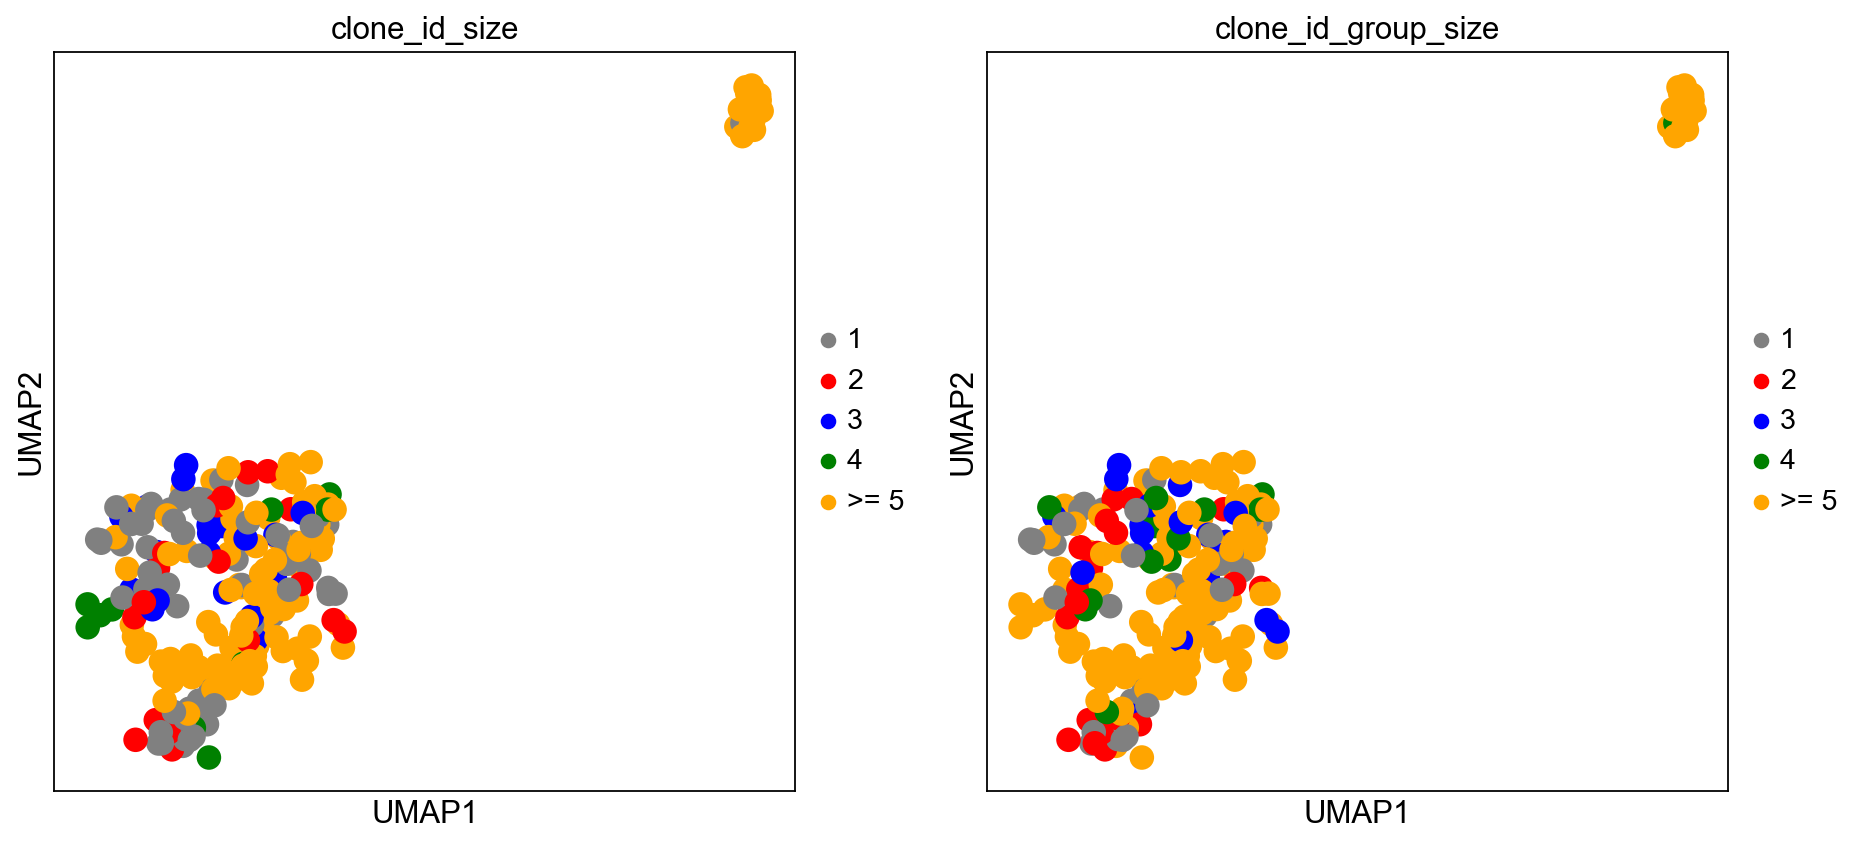

In [38]:
ddl.pl.clone_network(adata, color = ['clone_id_size', 'clone_id_group_size'], ncols = 2, legend_fontoutline=3, edges_width = 1, palette = ['grey', 'red', 'blue', 'green', 'orange', 'white'])
sc.pl.umap(adata[adata.obs['has_bcr'] == 'True'], color = ['clone_id_size', 'clone_id_group_size'], palette = ['grey', 'red', 'blue', 'green', 'orange', 'white'])

## Calculating diversity

### *clone_rarefaction*

We can use `pl.clone_rarefaction` to generate rarefaction curves for the clones. `tl.clone_rarefaction` will populate the `.uns` slot with the results. `groupby` option must be specified. In this case, I decided to group by sample. The function will only work on an `AnnData` object and not a `Dandelion` object.

removing due to zero counts: 


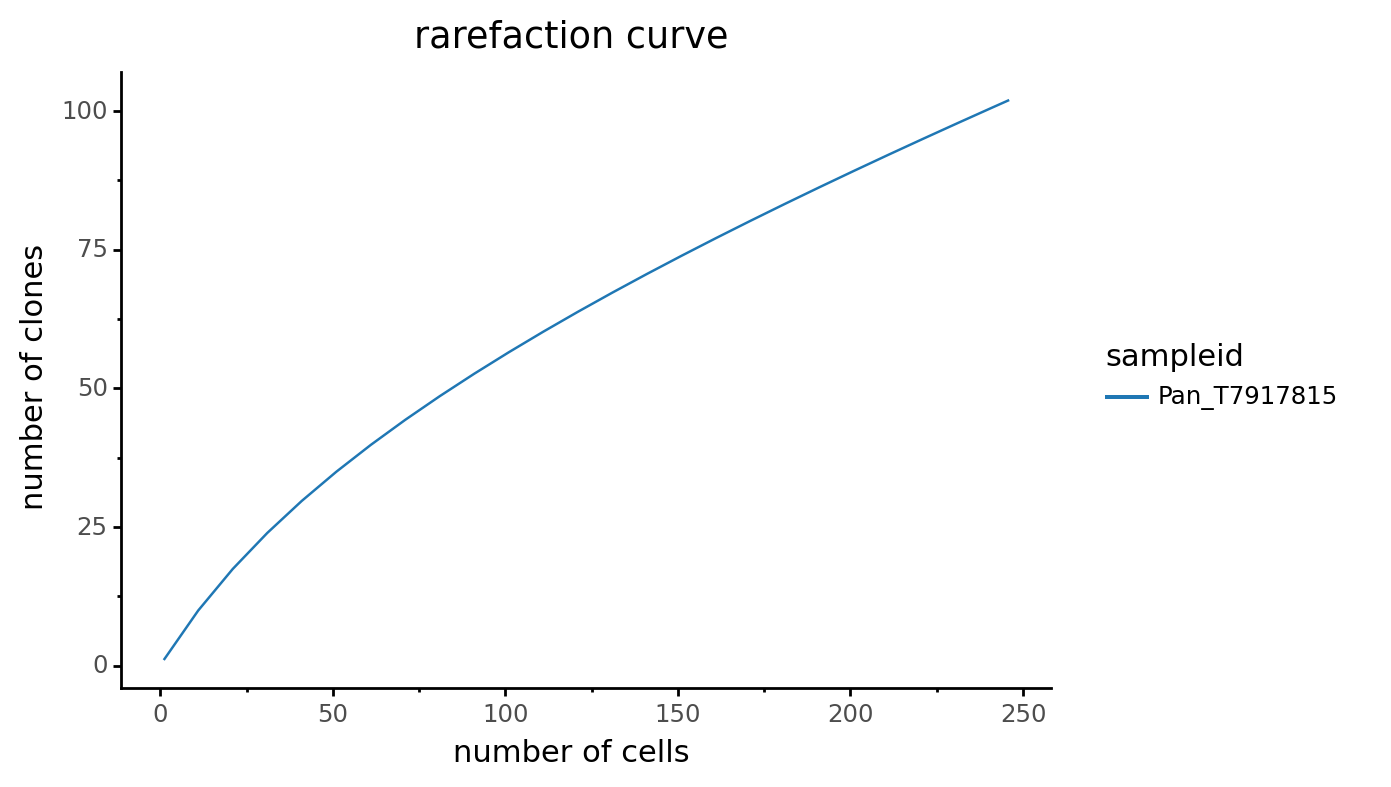

<ggplot: (319338161)>

In [39]:
ddl.pl.clone_rarefaction(adata, groupby = 'sampleid')

### *tl.clone_diversity*

`tl.clone_diversity` allows for calculation of diversity measures such as Chao1, Shannon Entropy and Gini indices. For Gini indices, we provide two types of measures: i) clone size and ii) clone degree. The rationale for i) is that samples with large disparity in clone sizes are more mutated, rather than samples with evenly sized clones; for ii), the distribution of the number of cells connected in each clone informs on whether clones in general are more monoclonal or polyclonal. In other words, a Gini index of 1 on either measure repesents perfect inequality (i.e. monoclonal and highly mutated) and a value of 0 represents perfect equality (i.e. polyclonal and unmutated). Thus before running `tl.clone_diversity` with `method = 'gini'`, we need to first run `tl.clone_degree`.

In [40]:
ddl.tl.clone_degree(results)
ddl.tl.transfer(adata, results)

Calculating clone degree
 finished: Updated Dandelion metadata
 (0:00:00)
Transferring network
converting matrices
Updating anndata slots
 finished: updated `.obs` with `.metadata`
added to `.uns['neighbors']` and `.obsp`
   'distances', cluster-weighted adjacency matrix
   'connectivities', cluster-weighted adjacency matrix (0:00:00)


The function can work on both `AnnData` and `Dandelion` objects. For `method = 'gini'`, `clone_degree` column is required in the `.obs` and `.metadata` slots respectively. One more note, the diversity tools has the option to perform resampling to the smallest sample size specified via `groupby` so that sample sizes are even when comparing between groups.

In [41]:
ddl.tl.clone_diversity(results, groupby = 'sample_id', method = 'gini', update_obs_meta = False)

Calculating Gini indices


,clone_size_gini,clone_degree_gini
Pan_T7917815,0.471066,0.514162


In [42]:
ddl.tl.clone_diversity(adata, groupby = 'sampleid', method = 'gini', update_obs_meta = False)

Calculating Gini indices


,clone_size_gini,clone_degree_gini
Pan_T7917815,0.471066,0.514162


In [43]:
ddl.tl.clone_diversity(results, groupby = 'sample_id', method = 'chao1', update_obs_meta = False)

Calculating Chao1 estimates


,clone_size_chao1
Pan_T7917815,329.8


For Shannon Entropy, we can calculate a normalized and non-normalized value.

In [44]:
ddl.tl.clone_diversity(results, groupby = 'sample_id', method = 'shannon', update_obs_meta = False)

Calculating Shannon entropy


,clone_size_shannon
Pan_T7917815,0.893659


In [45]:
ddl.tl.clone_diversity(results, groupby = 'sample_id', method = 'shannon', update_obs_meta = False, normalize = False)

Calculating Shannon entropy


,clone_size_shannon
Pan_T7917815,5.962872


#### Saving
At this stage, the data can be saved. For scanpy objects they can be saved as per usual using `.write` module. With the `Dandelion` class, we can save it with `pickle` via `.write`:

In [46]:
results.write('Pan_immune_BCR/Pan_T7918901/dandelion/data/dandelion_results.pkl.pbz2')

if you need to save the contig table as a .tsv file to interact with other packages, you can use `pandas.DataFrame.to_csv` on the `.data` slot of the `Dandelion` class object.

In [47]:
results.data.to_csv('Pan_immune_BCR/Pan_T7918901/dandelion/data/results.tsv', sep ='\t', index = False)

## Additional plotting functions

## *barplot*
`pl.barplot` is a generic barplot function that will plot items in the metadata slot as a bar plot. This function will also interact with `.obs` slot if a `scanpy` object is used in place of `Dandelion` object. However, if your `scanpy` object holds a lot of non-B cells, then the plotting will be just be saturated with nan values.

(<Figure size 1200x400 with 1 Axes>,
 <AxesSubplot:title={'center':'v call heavy usage'}, ylabel='proportion'>)

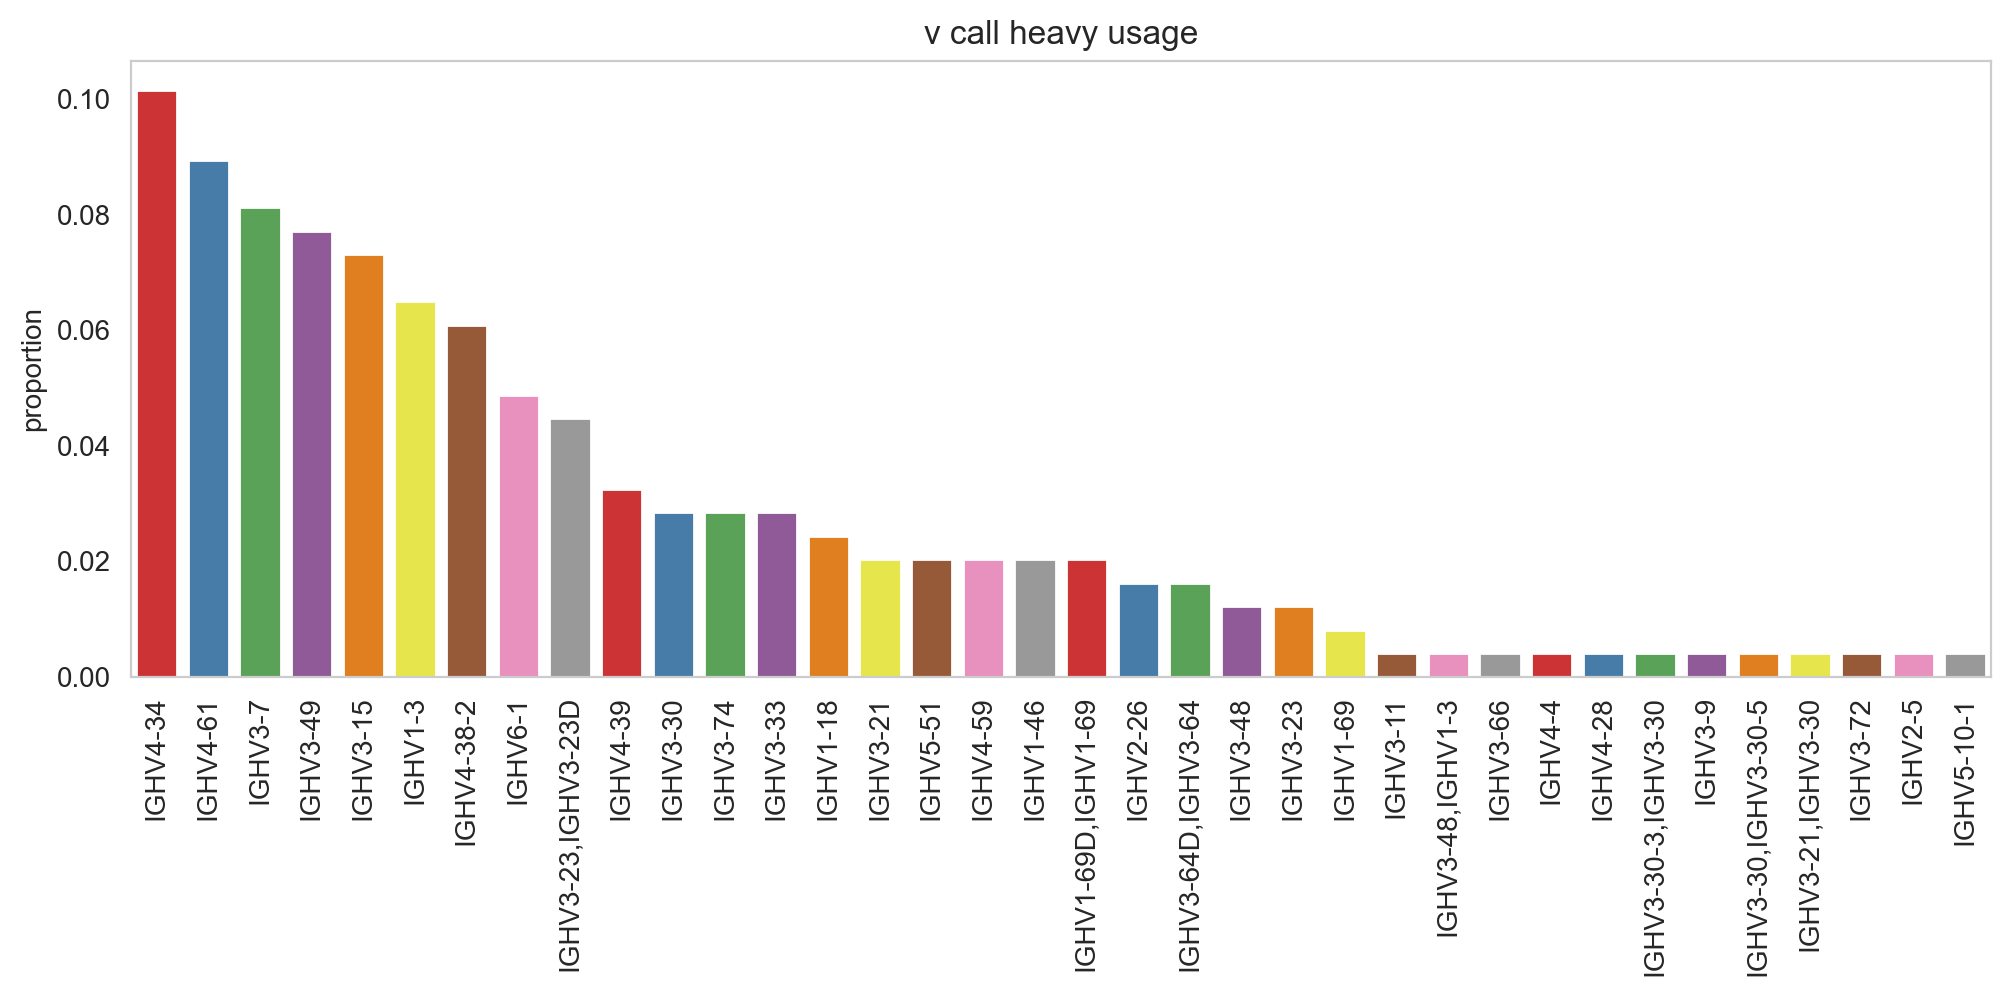

In [48]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
ddl.pl.barplot(results, variable = 'v_call_heavy', figsize = (12, 4))

You can prevent it from sorting by specifying `sort_descending = None`. Colours can be changed with `palette` option.

(<Figure size 1200x400 with 1 Axes>,
 <AxesSubplot:title={'center':'v call heavy usage'}, ylabel='proportion'>)

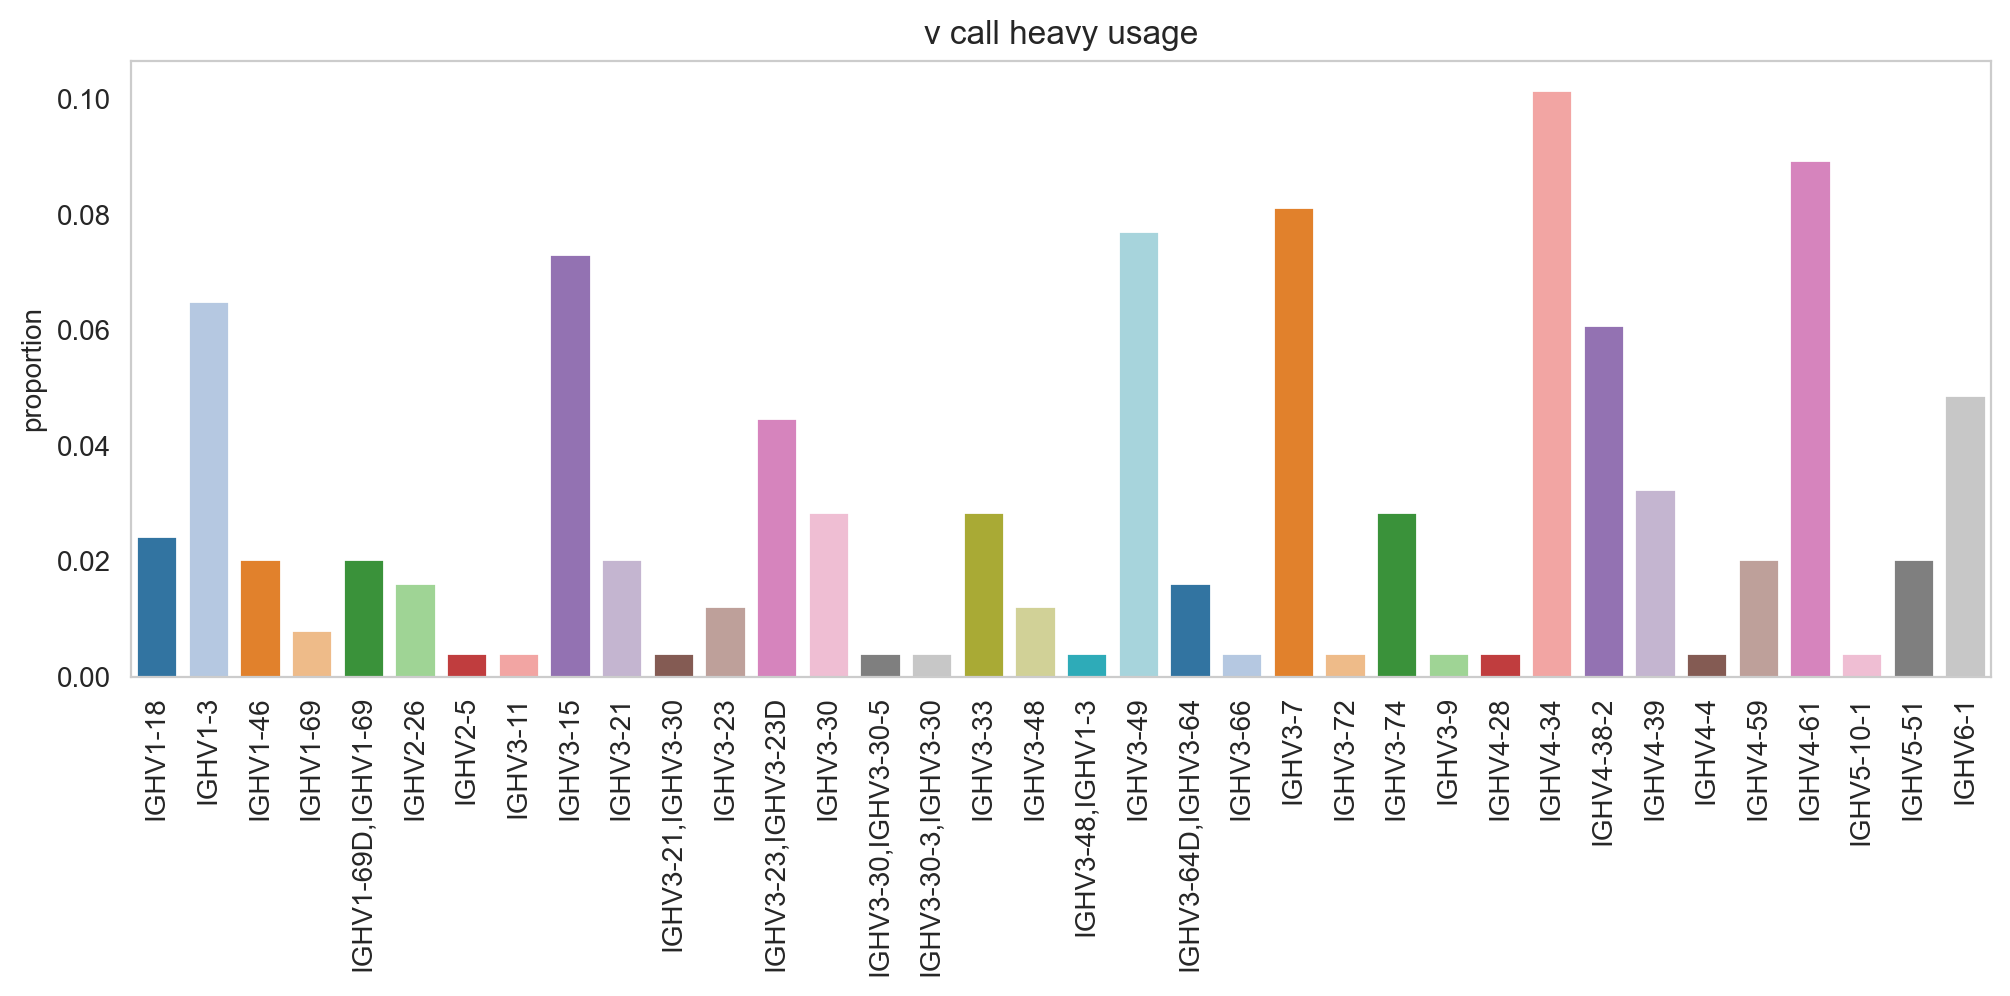

In [49]:
ddl.pl.barplot(results, variable = 'v_call_heavy', figsize = (12, 4), sort_descending = None, palette = 'tab20')

Specifying `normalize = False` will change the y-axis to counts.

(<Figure size 1200x400 with 1 Axes>,
 <AxesSubplot:title={'center':'v call heavy usage'}, ylabel='count'>)

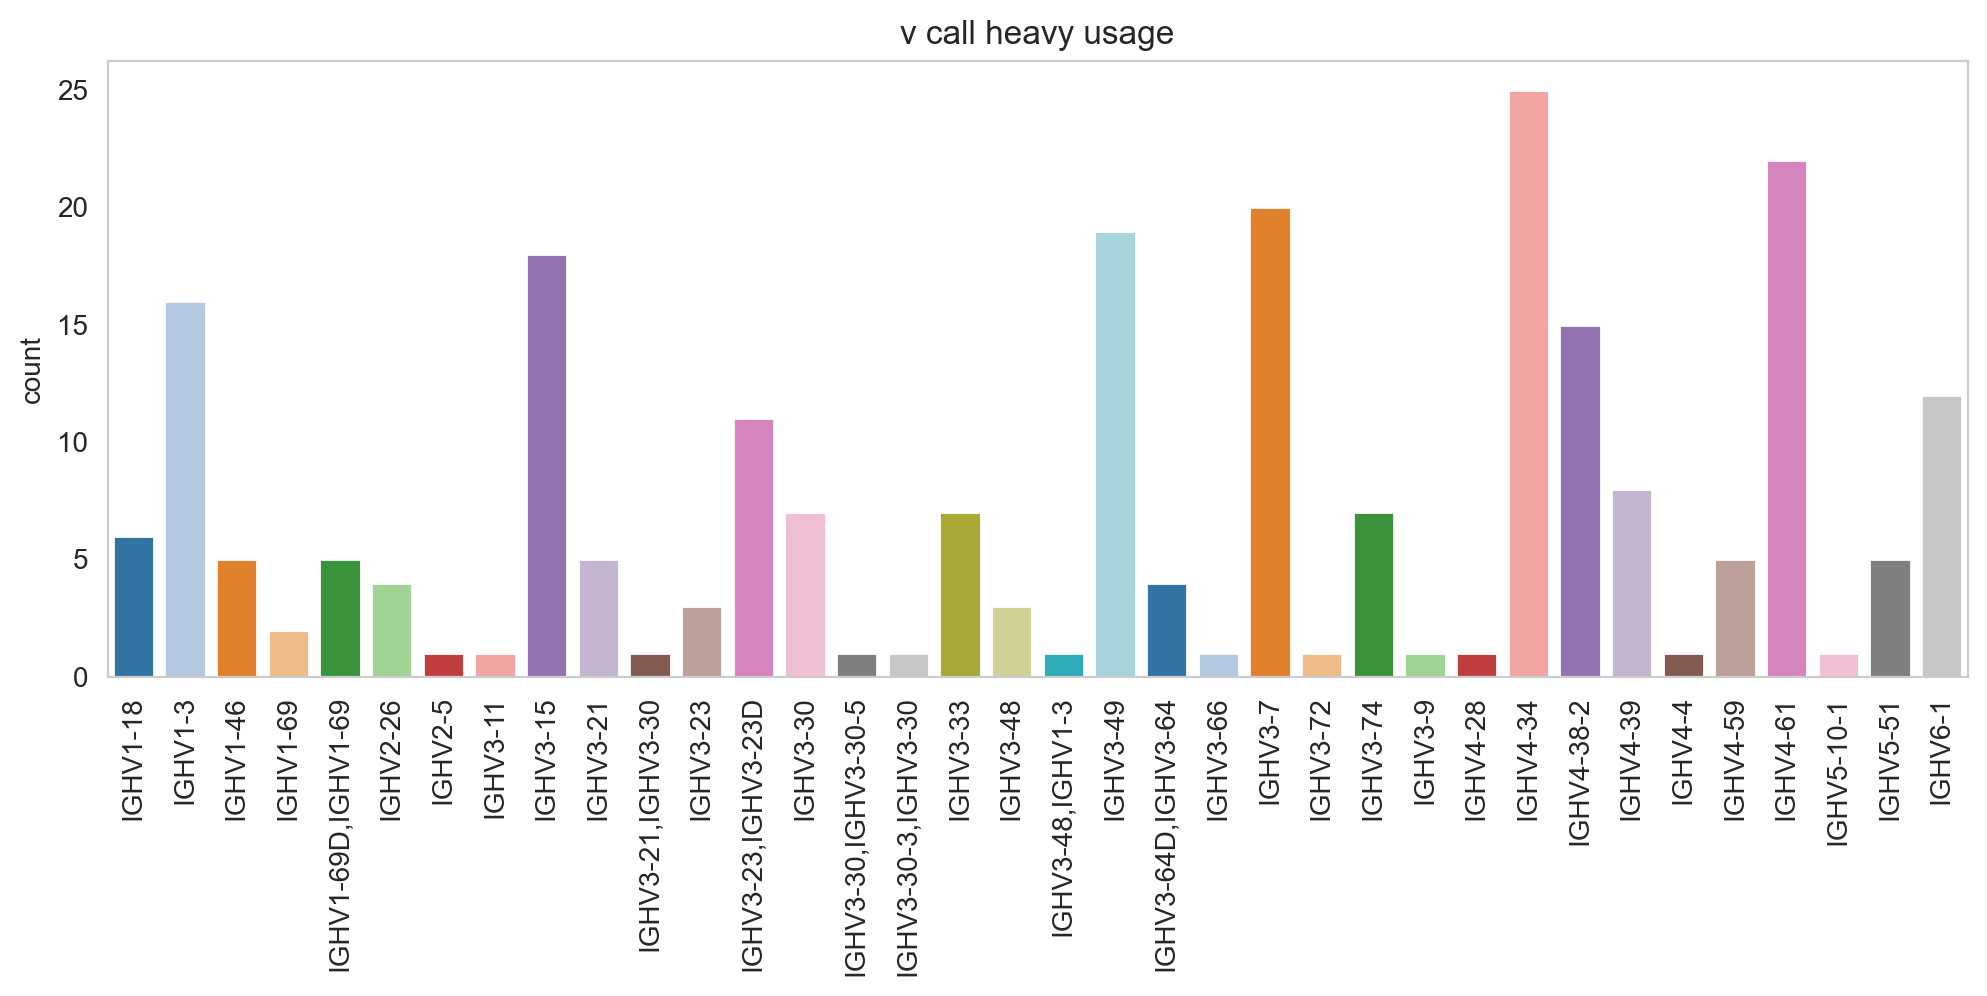

In [50]:
ddl.pl.barplot(results, variable = 'v_call_heavy', normalize = False, figsize = (12, 4), sort_descending = None, palette = 'tab20')

## *stackedbarplot*
`pl.stackedbarplot` is similar to above but can split between specified groups. Some examples below:

(<Figure size 400x400 with 1 Axes>,
 <AxesSubplot:title={'center':'multiple stacked bar plot : isotype usage'}, ylabel='count'>)

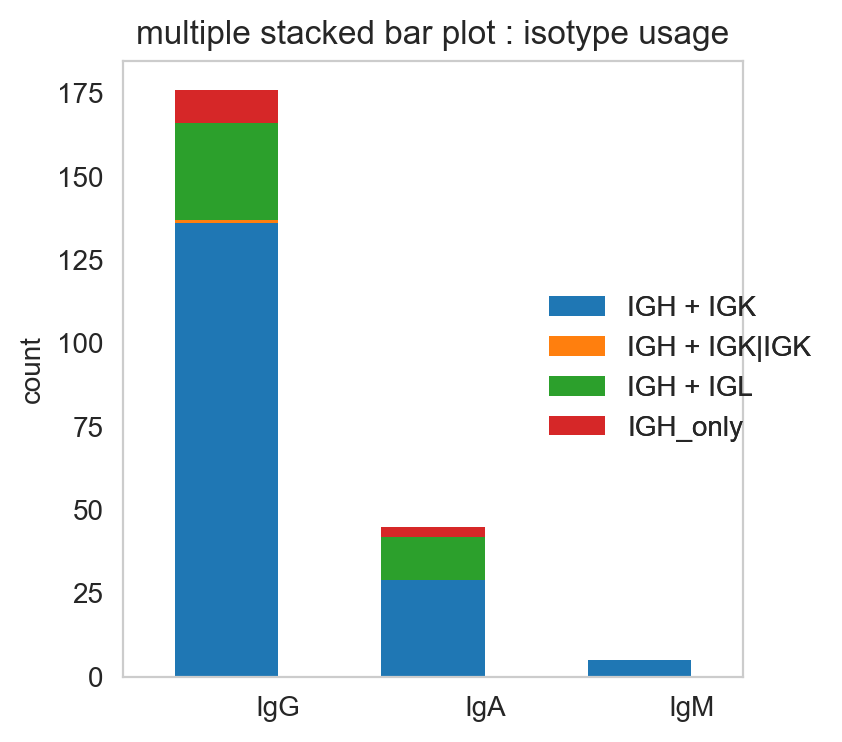

In [51]:
ddl.pl.stackedbarplot(results, variable = 'isotype', groupby = 'status', xtick_rotation =0, figsize = (4,4))

(<Figure size 1200x400 with 1 Axes>,
 <AxesSubplot:title={'center':'multiple stacked bar plot : v call heavy usage'}, ylabel='count'>)

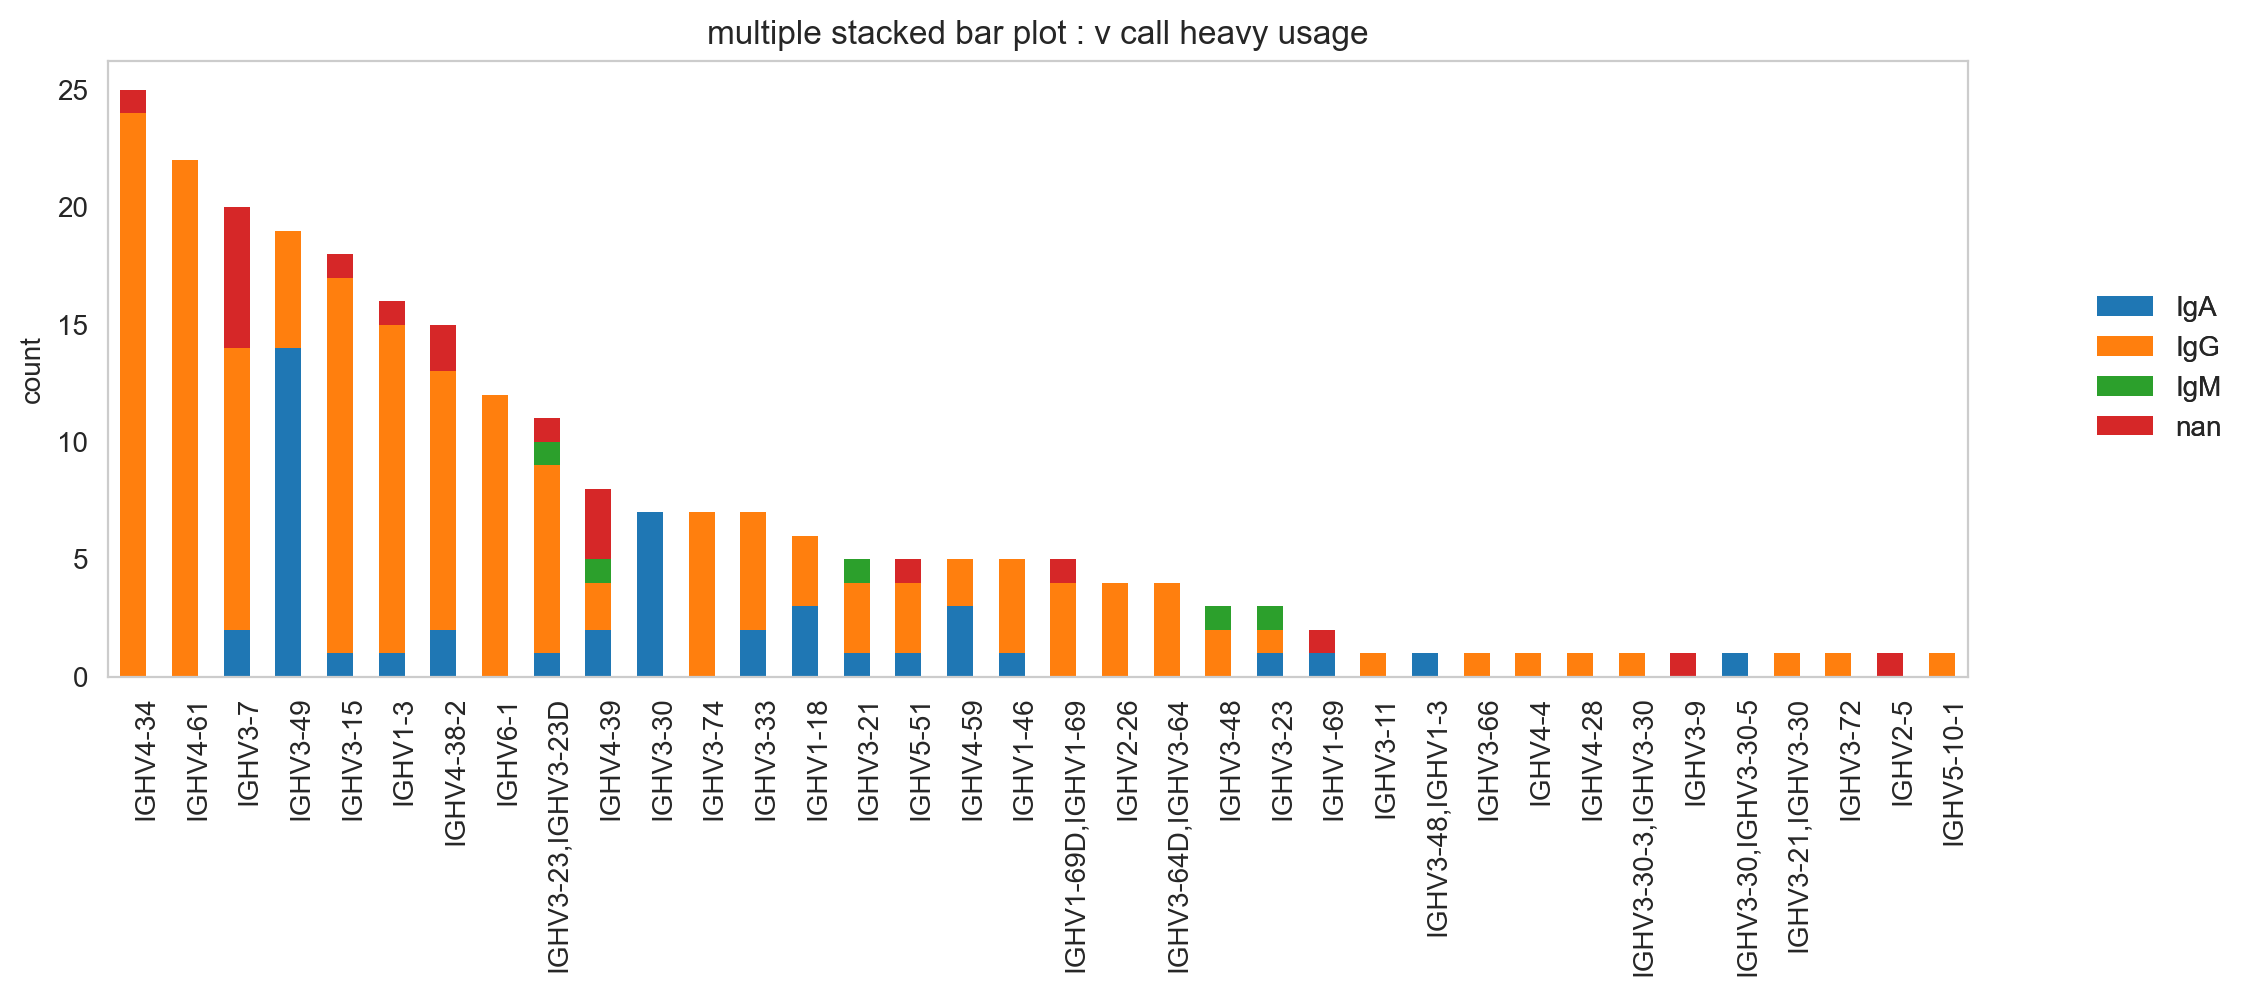

In [52]:
ddl.pl.stackedbarplot(results, variable = 'v_call_heavy', groupby = 'isotype')

(<Figure size 1200x400 with 1 Axes>,
 <AxesSubplot:title={'center':'multiple stacked bar plot : v call heavy usage'}, ylabel='proportion'>)

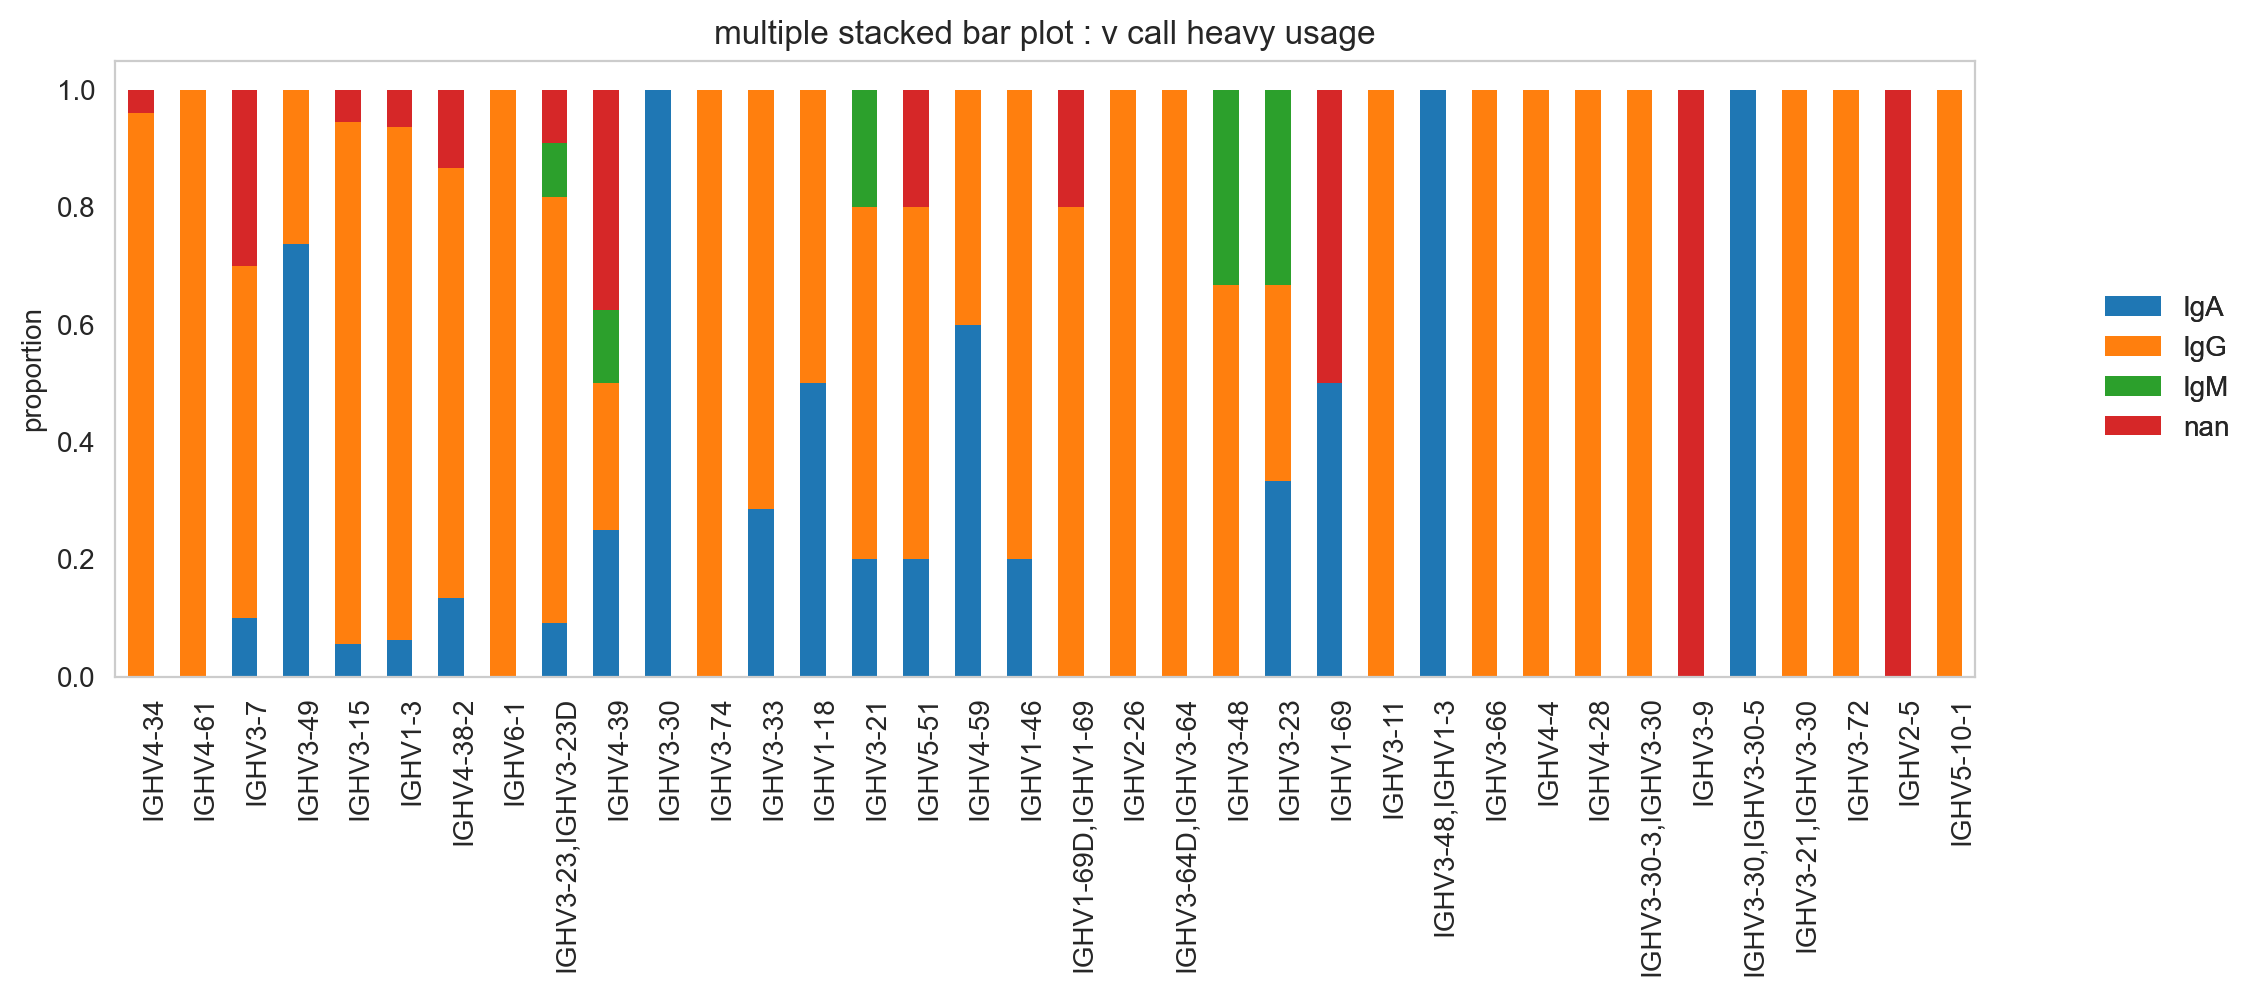

In [53]:
ddl.pl.stackedbarplot(results, variable = 'v_call_heavy', groupby = 'isotype', normalize = True)

(<Figure size 1200x400 with 1 Axes>,
 <AxesSubplot:title={'center':'multiple stacked bar plot : v call heavy usage'}, ylabel='count'>)

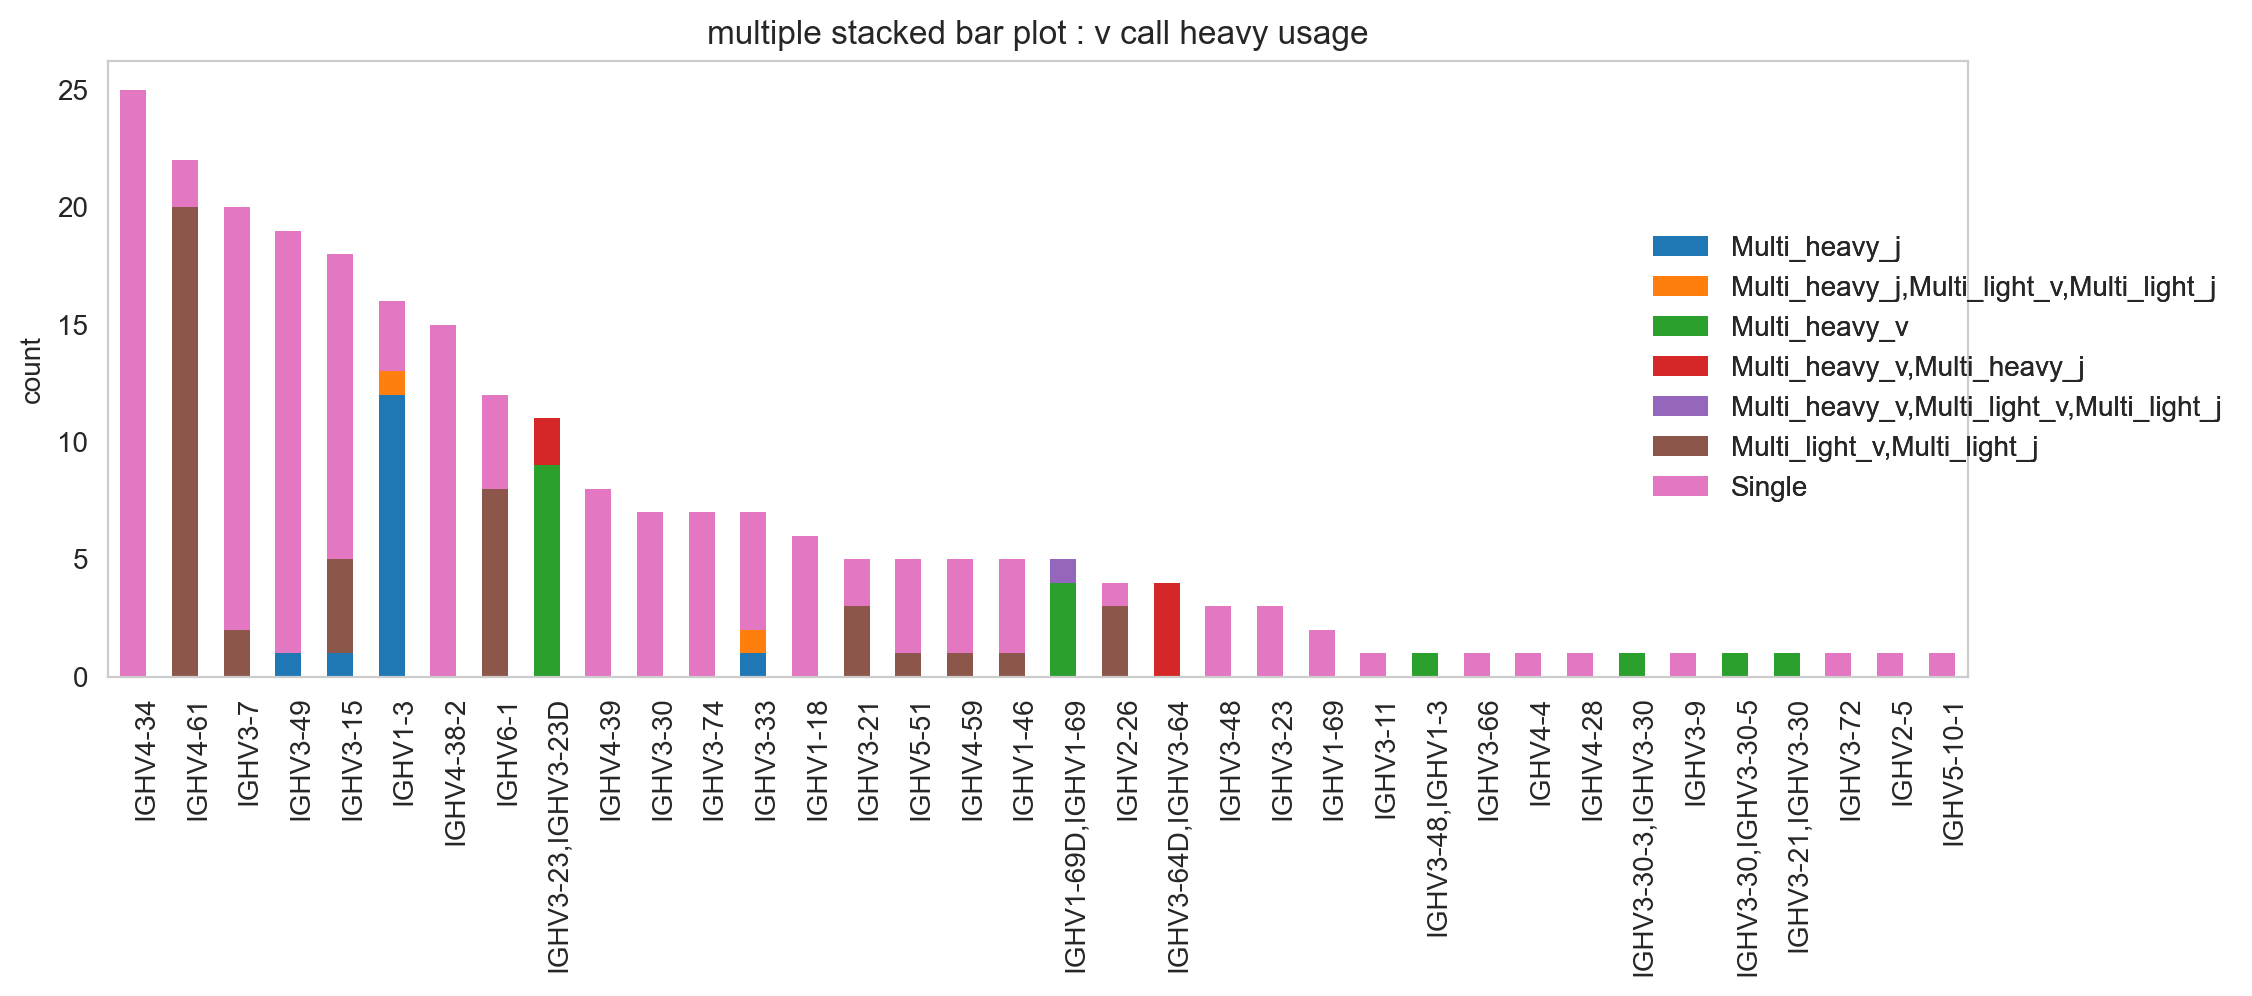

In [54]:
ddl.pl.stackedbarplot(results, variable = 'v_call_heavy', groupby = 'vdj_status')

It's obviously more useful if you don't have too many groups, but you could try and plot everything and jiggle the legend options and color.

(<Figure size 1200x400 with 1 Axes>,
 <AxesSubplot:title={'center':'multiple stacked bar plot : v call heavy usage'}, ylabel='count'>)

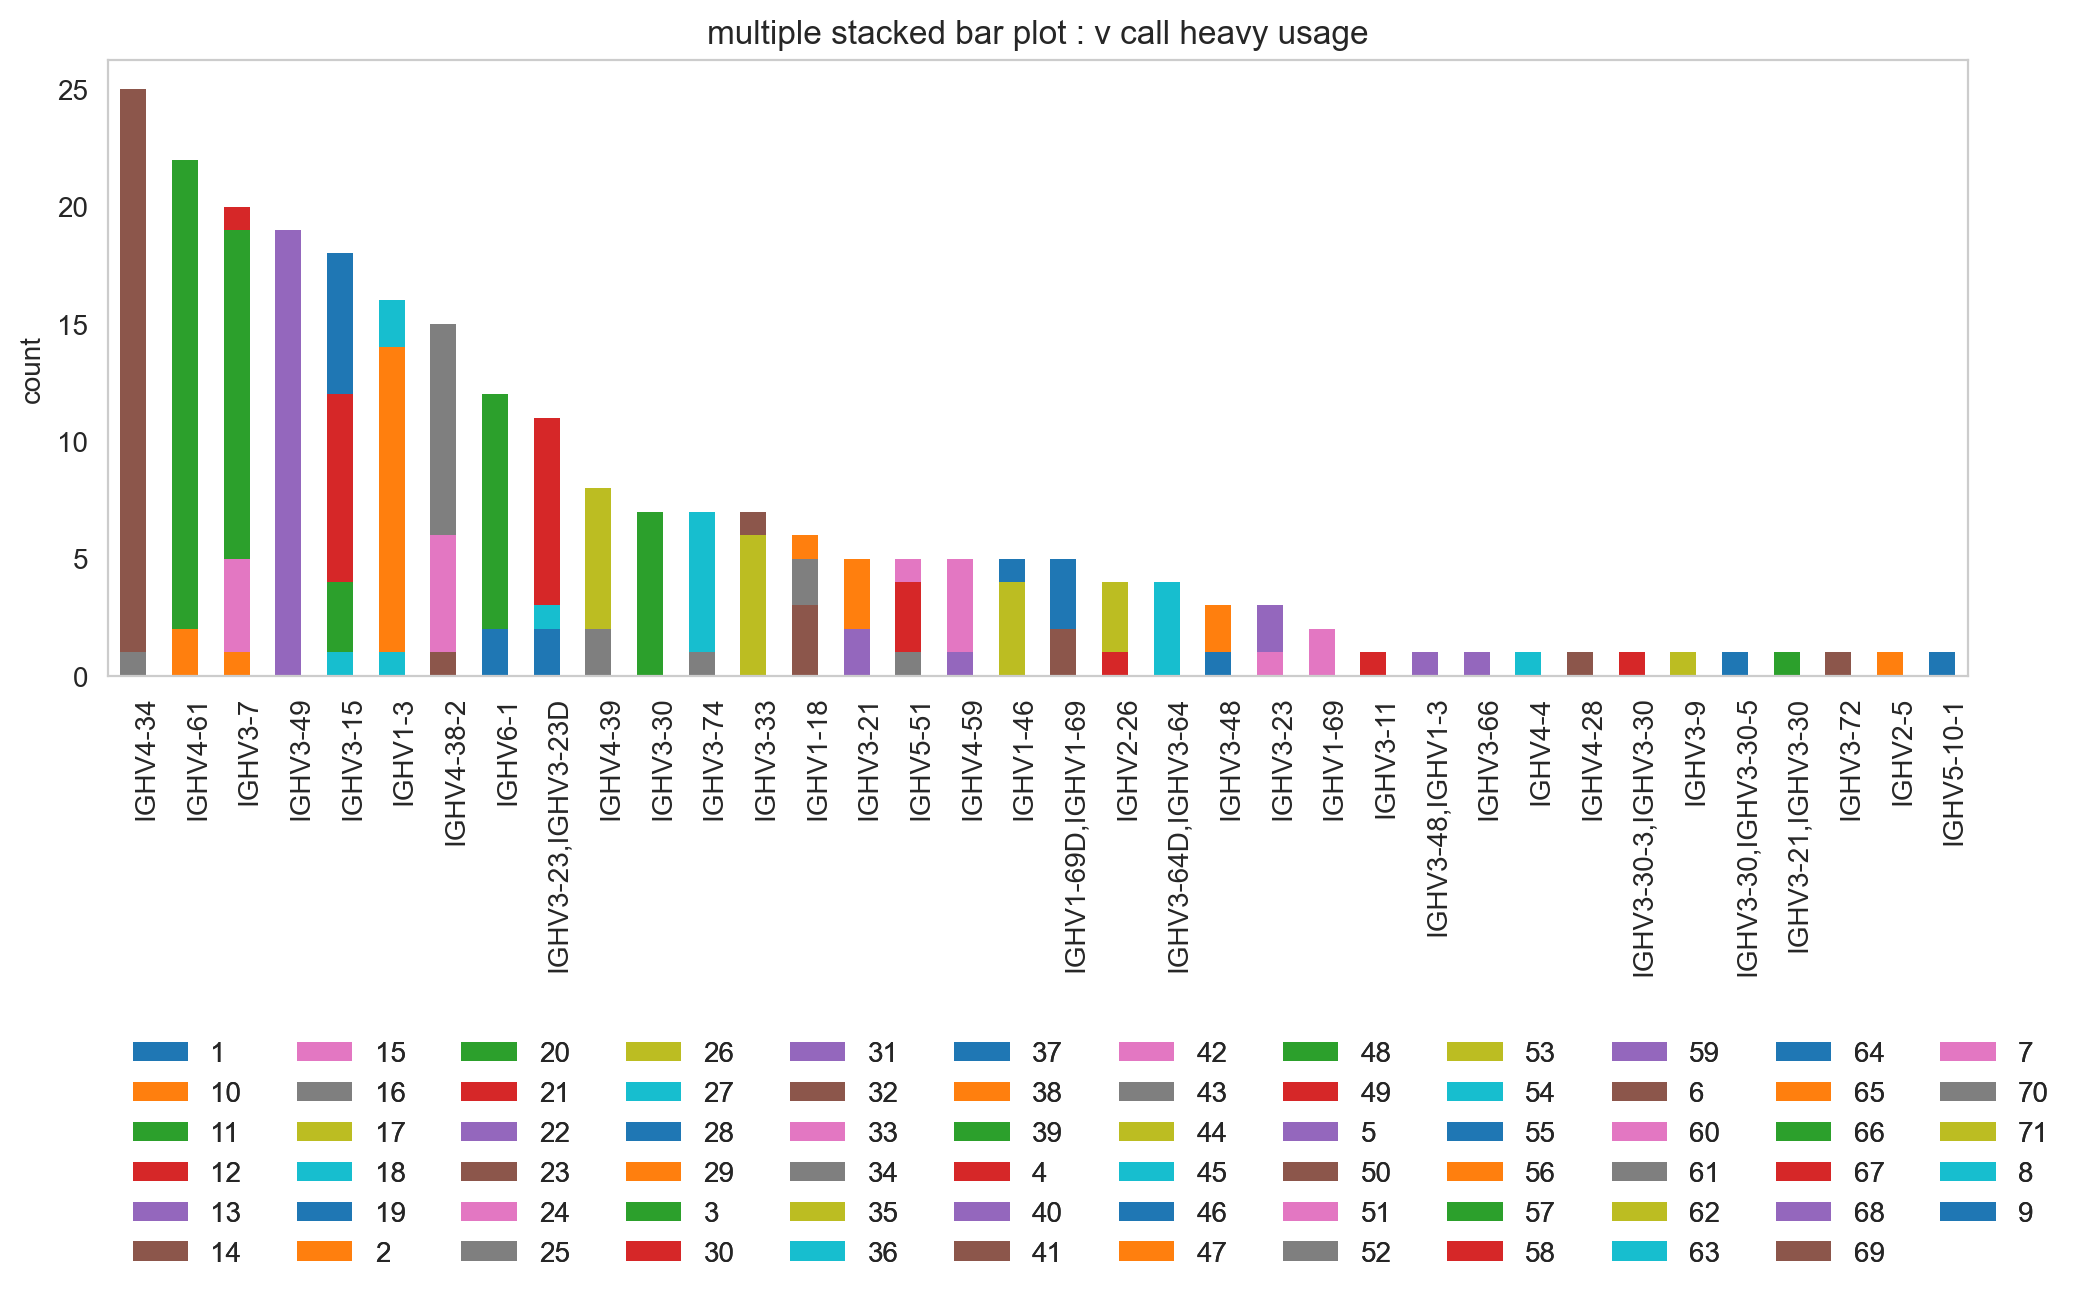

In [55]:
ddl.pl.stackedbarplot(results, variable = 'v_call_heavy', groupby = 'clone_id_group', legend_options = ('lower left', (0, -1), 12))

## *spectratype*
Spectratype plots contain info displaying CDR3 length distribution for specified groups. For this function, the current method only works for `dandelion` objects as it requires access to the contig-indexed *.data* slot.

(<Figure size 600x400 with 1 Axes>,
 <AxesSubplot:xlabel='junction_length', ylabel='count'>)

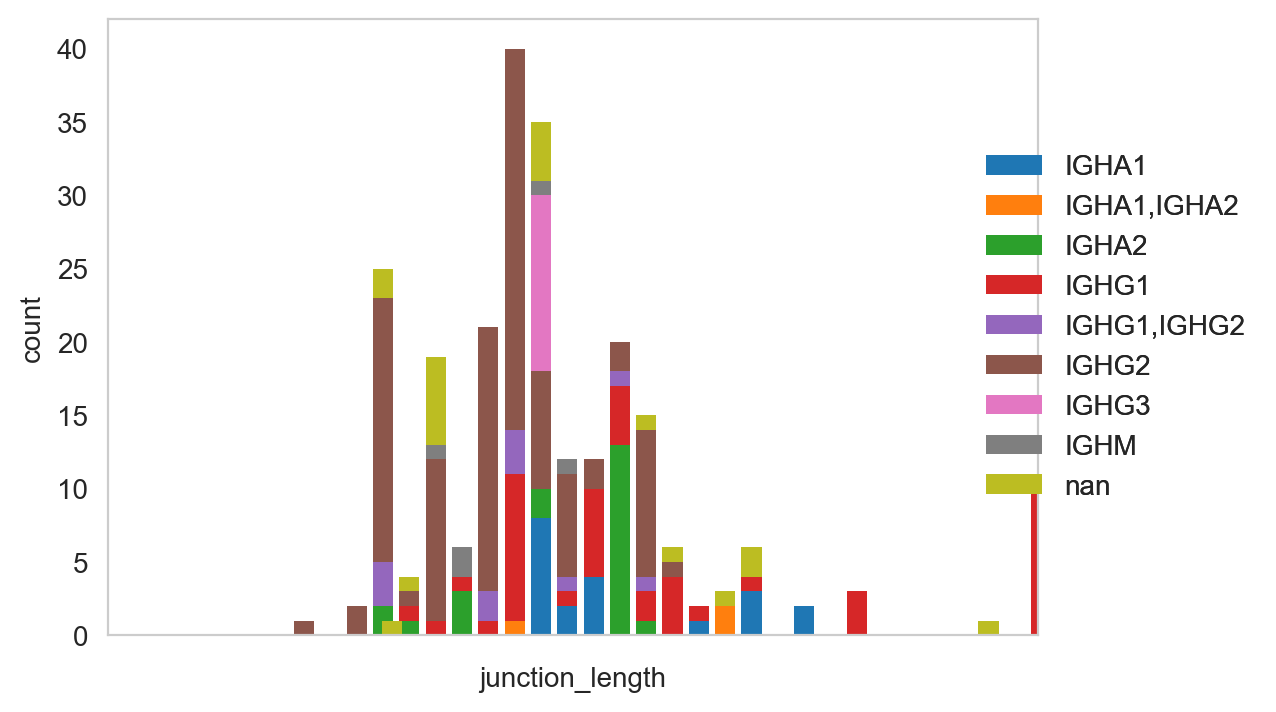

In [56]:
ddl.pl.spectratype(results, variable = 'junction_length', groupby = 'c_call', locus='IGH', width = 2.3)

(<Figure size 600x400 with 1 Axes>,
 <AxesSubplot:xlabel='junction_aa_length', ylabel='count'>)

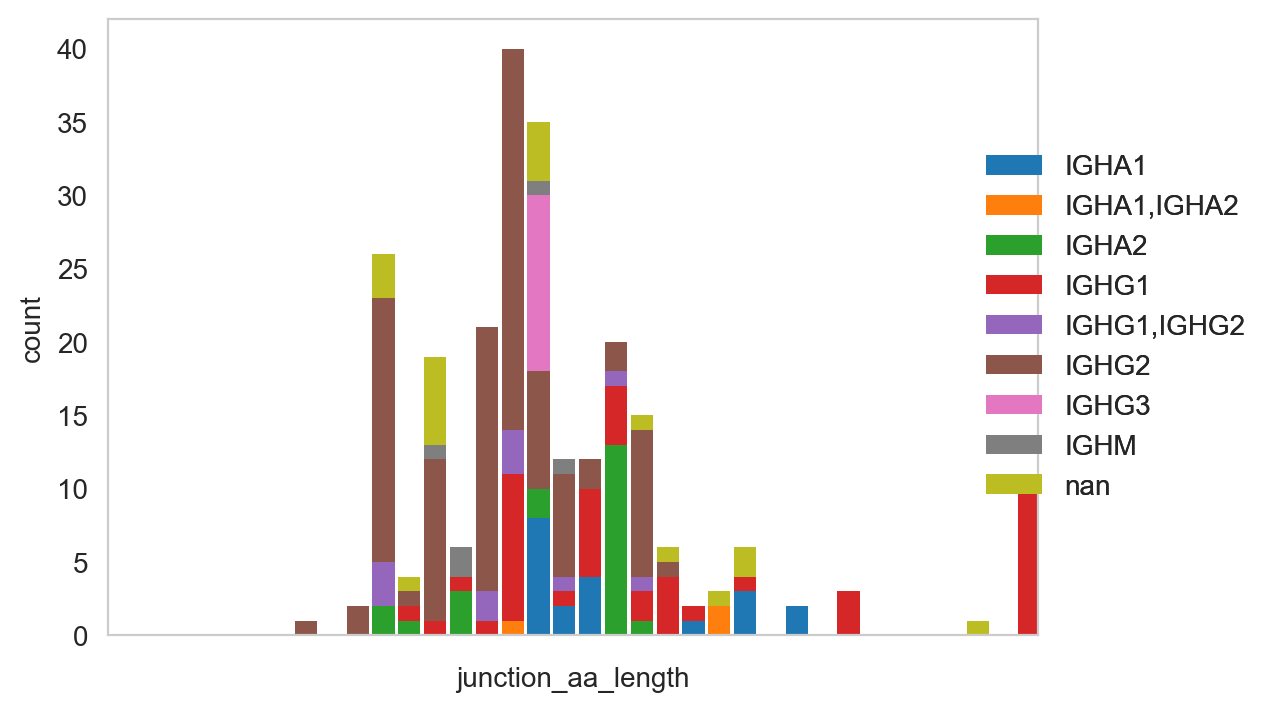

In [57]:
ddl.pl.spectratype(results, variable = 'junction_aa_length', groupby = 'c_call', locus='IGH')

(<Figure size 600x400 with 1 Axes>,
 <AxesSubplot:xlabel='junction_aa_length', ylabel='count'>)

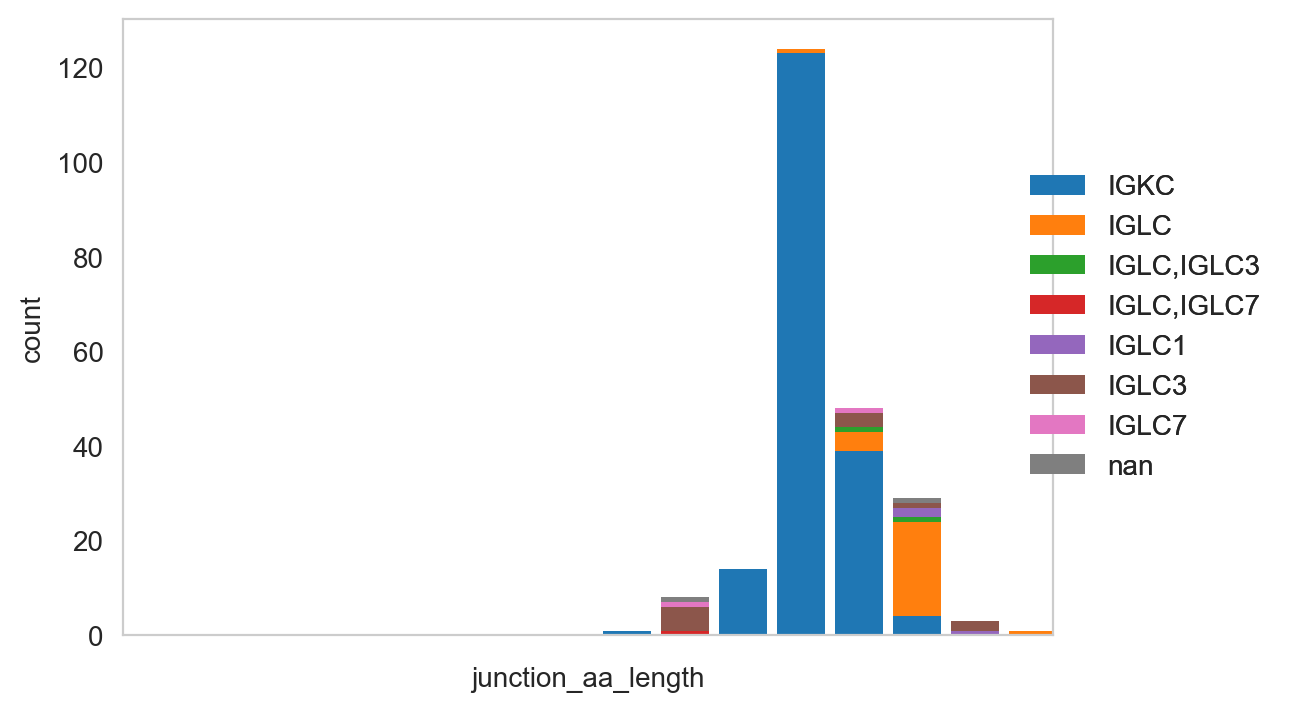

In [58]:
ddl.pl.spectratype(results, variable = 'junction_aa_length', groupby = 'c_call', locus=['IGK','IGL'])

(<Figure size 600x400 with 1 Axes>,
 <AxesSubplot:xlabel='junction_aa_length', ylabel='count'>)

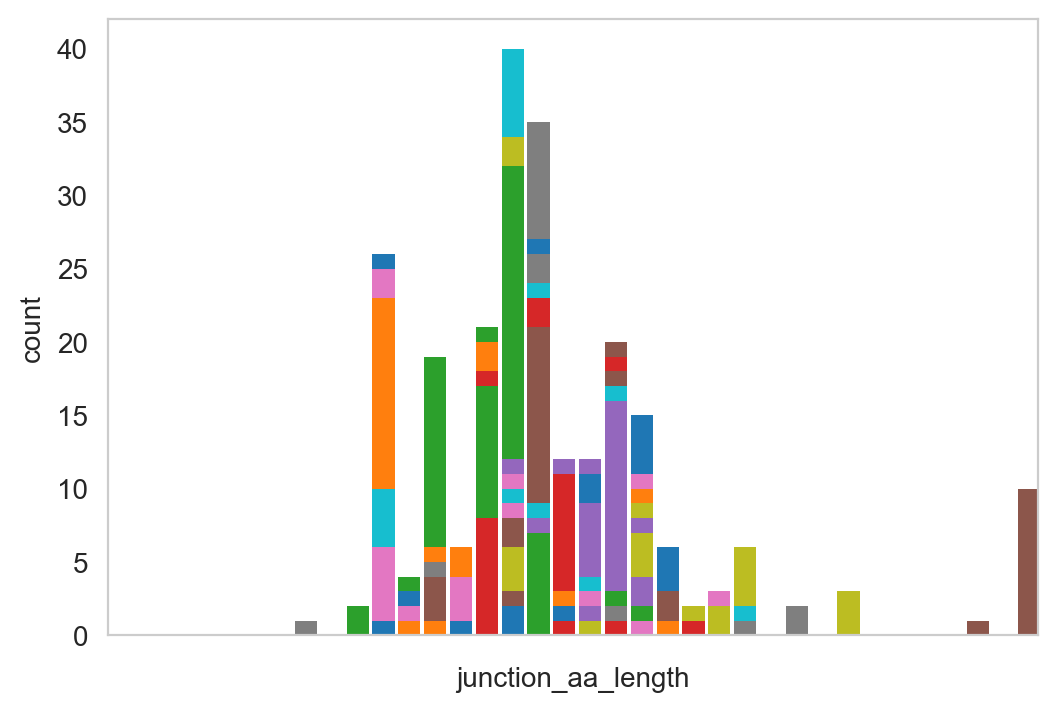

In [59]:
ddl.pl.spectratype(results, variable = 'junction_aa_length', groupby = 'clone_id_group', locus='IGH', hide_legend = True)

That sums it up for now! Let me know if you have any ideas at [kt16@sanger.ac.uk] and I can try and see if i can implement it or we can work something out to collaborate on!